# CAB420 Assignment 1B Question 2: Template

## Overview

This notebook provides a helper function to load in the Oxford-IIIT Pets dataset suitable for classification and semantic segmentation, to help with Assignment 1B, Question 2.

It also provides an example of how to load in the MobileNetV3Small Network which you are required to fine tune for the second part of the question.

Please read the comments and instructions within this notebook. It has been carefully designed to help you with many of the tasks required.

Please make sure you read the assignment brief on canvas, and check the FAQ for other information.

In [1]:
!pip install --upgrade tensorflow_datasets
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt
from matplotlib import gridspec

import tensorflow as tf
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation, Flatten
from keras.models import Model

import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import glob

import sklearn.metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



E0000 00:00:1746338466.555554   23999 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746338466.568259   23999 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Data loading and pre-processing functions

We first provide some helper functions to format the data in the way we need. You shouldn't need to change these, though you are welcome to if you like.

One thing you may want to do is create additional augmentation functions, and the ``flip_lr_augmentation`` function below could be used as a template to create additional augmentation types. 

In [2]:
def preprocess_segmentation_mask(segmentation_mask):
    """preprocess the semgentation mask

    The original segmentation mask has three categories.
      foreground, background and outline
    This function will just convert it to foreground and background 

    The original segmentation mask is also 1-index, so will convert it
    to 0-index.

    the original mask is represented as:
    1 - edge of dog/cat and things like leashes etc.
    2 - background
    3 - foreground

    we want to just keep the merge the edges and foreground of the doggo/catto, and
    then treat it as a binary semantic segmentation task.
    To achieve this, we will just subtract two, converting to values of [-1, 0, 1],
    and then apply the abs function to convert the -1 values (edges) to the foreground.

    Will also convert it to 32 bit float which will be needed for working with tf.
    
    Why am I doing it this way?
     A reasonable question. Initially I tried to do it with just normal array indexing,
     but this is a bit more work since the mask is a tensorflow tensor and not a np array.
     We could alternatively convert it to an array, perform indexing and then map it back,
     but this would have a performance overhead, which wouldn't be a big deal, but still.
     With all that being said, I am doing it for you, so you don't have to.

    Args:
      segmentation_mask (array):
        original segmentation mask

    Returns:
      preprocessed segmentation_mask
    """
    return tf.abs(tf.cast(segmentation_mask, tf.float32) - 2)

def return_image_label_mask(ds_out):
    """ function to return image, class label and segmentation mask

    The original dataset contains additional information, such as the filename and
    the species. We don't care about any of that for this work, so will
    discard them and just keep the original image as our input, and then
    a tuple of our outputs that will be the class label and the semantic
    segmentation mask.

    Whilst we are here, we will also preprocess the segmentation mask.

    Args:
      ds_out: dict
        original dataset output

    Returns:
       RGB image
       tuple of class label and preprocessed segmentation mask
    """
    # preprocess the segmentation mask
    seg_mask =  preprocess_segmentation_mask(ds_out['segmentation_mask'])
    image = tf.cast(ds_out['image'], tf.float32)
    # image = standardise_image(image)
    return image, (ds_out['label'], seg_mask)

def mobilenet_preprocess_image(image):
    """Apply preprocessing that is suitable for MobileNetV3.
    
    Simply scales to ranges [-1, 1]
    
    
    you should use this preprocessing for both your model and the mobilenet model
    """
    image = (image - 127.5) / 255.0
    return image
        
def unprocess_image(image):
    """ undo preprocessing above so can plot images"""
    image = image * 255.0 + 127.5
    return image

def preprocess_and_resize(image, output, image_size):
    """apply preprocessing steps above to images and resize images and maps
    
    Each image in the dataset is of a different size. The resizing will make sure
    each image is the same size.
    """
    # resize the image and the semantic segmentation mask
    image = tf.image.resize(image, [image_size, image_size])
    image = mobilenet_preprocess_image(image)
    mask = tf.image.resize(output[1], [image_size, image_size])
    return image, (output[0], mask)

def flip_lr_augmentation(image, output, flip_lr_prob):
    """ function to return perform left-right flip augmentation

    The function will flip the image along the left-right axis with
    a defined probability.
    """

    # randomly sample a value between 0 and 1
    uniform_sample = tf.random.uniform([], minval=0, maxval=1)
    # perform flip_lr with probability given by flip_lr_prob 
    flip_lr_cond = tf.math.less(uniform_sample, flip_lr_prob)
    # output is a tuple of (class, segmentation_mask), pull out the segmentation mask
    seg = output[1]
    
    # wrapper fn for when we do the flip
    def flip():
        flipped_image = tf.image.flip_left_right(image)
        flipped_seg = tf.image.flip_left_right(seg)
        return flipped_image, flipped_seg

    # wrapper fn for when we do NOT flip
    def no_flip():
        return image, seg

    # apply augmentation    
    image, seg = tf.cond(flip_lr_cond, flip, no_flip)
    # return the image, and output
    return image, (output[0], seg)

def select_tasks(image, output, classification=True, segmentation=True):
    """select the tasks to include the data

    By default for each input there are two outputs. This function allows
    you to select which outputs to use, so the problem can be reduced to a
    single task problem for initial experimenting.    
    """
    # both tasks
    if classification and segmentation:
        return image, output
    # just classification
    elif classification:
        return image, output[0]
    # just segmentation
    elif segmentation:
        return image, output[1]
    # neither task, doesn't really make sense, so return the image
    # for a self-supervised task
    else:
        return image, image

class TrainForTime(keras.callbacks.Callback):
    """callback to terminate training after a time limit is reached

    Can be used to control how long training runs for, and will terminate
    training once a specified time limit is reached.
    """
    def __init__(
        self,
        train_time_mins=15,
    ):
        super().__init__()

        self.train_time_mins = train_time_mins
        self.epochs = 0
        self.train_time = 0
        self.end_early = False

    def on_train_begin(self, logs=None):
        # save the start time
        self.start_time = tf.timestamp()

    def on_epoch_end(self, epoch, logs=None):
        self.epochs += 1
        current_time = tf.timestamp()
        training_time = (current_time - self.start_time)
        if (training_time / 60) > self.train_time_mins:
            self.train_time = current_time - self.start_time
            self.model.stop_training = True
            self.end_early = True


    def on_train_end(self, logs=None):
        if self.end_early:
            print('training time exceeded and ending early')
            print(f'training ended on epoch {self.epochs}')
            print(f'training time = {self.train_time / 60} mins')

### Data Loader

We will now put the above functions together into a data loader that we can use to feed directly to the network. You can you this directly as it is. However, you may modify it to add some additional functionality such as further data augmentations.

In [3]:
def load_oxford_pets1(split,
                     batch_size=233,
                     classification=True,
                     segmentation=True,
                     shuffle=True,
                     augment=True,
                     image_size=300):
    """Load Oxford pets dataset for Assignment 1B

    Function handles loading of data for 1b, included processing of images and
    semantic segmentation masks. This function will
    organise the tensorflow dataset to return an output that is a tuple, where
    the tuple will be (classification_labels, segmentation_masks).

    Parameters
    ----------
    split : string
        either train, val or test string
    classification : bool
        whether to include classification labels
    segmentation : bool
        whether to include semantic segmentation masks
    batch_size : int
        size of batches to use
    shuffle : bool
        whether to shuffle the dataset (WILL ONLY APPLY TO TRAIN)
    augment : bool
        whether to augment the dataset (WILL ONLY APPLY TO TRAIN)
    image_size : int
        new image size

    Returns
    -------
       tf.Dataset containing the Oxford pets dataset
    """
    # lets do some error checking first
    # Check fior a valid dataset split, this must be train or test
    if (split != 'train') and (split != 'val') and (split != 'test'):
        raise ValueError('Arg for split must be either \'train\' or \'test\'')
    if (not classification) and (not segmentation):
        print("WARNING: One of the tasks (classification and segmentation) must be selected")
        print("Setting both to enabled")
        classification = True
        segmentation = True
        
    # check that if using the val split, shuffle if false. If not, print a warning and force shuffle to be false
    if (split == 'val') and shuffle:
        print("WARNING: shuffle is set to true, but have specified split to be \'val\'")
        print('The shuffle argument will be ignored')
        shuffle = False
        
    # check that if using the test split, shuffle if false. If not, print a warning and force shuffle to be false
    if (split == 'test') and shuffle:
        print("WARNING: shuffle is set to true, but have specified split to be \'test\'")
        print('The shuffle argument will be ignored')
        shuffle = False
        
    # check that if using the val split, augment if false. If not, print a warning and force augment to be false
    if (split == 'val') and augment:
        print("WARNING: augment is set to true, but have specified split to be \'val\'")
        print('The augment argument will be ignored')
        augment = False
        
    # check that if using the test split, augment if false. If not, print a warning and force augment to be false
    if (split == 'test') and augment:
        print("WARNING: augment is set to true, but have specified split to be \'test\'")
        print('The augment argument will be ignored')
        augment = False
        
    # the dataset by default only has train and test splits. If val is requested, pull the first 30% of the test set
    if (split == 'val'):
        split = 'test[:30%]'
    # the test set then becomes the remaining 70% of the original test set
    elif (split == 'test'):
        split = 'test[30%:]'
   
    # now start loading the dataset
    ds = tfds.load('oxford_iiit_pet',
                   split=split,
                   with_info=False)
    
    # remove unnecessary dataset info
    ds = ds.map(return_image_label_mask)

    # augmentation
    # only apply if in the training split and augment has been set to True
    if split == 'train' and augment:
        # apply a left-right flip with 50% probability
        flip_lr_prob = 0.5
        # flip operation
        ds = ds.map(lambda inp, out: flip_lr_augmentation(inp, out, flip_lr_prob), num_parallel_calls=tf.data.AUTOTUNE)

        # more augmentation operations could go here .....
    
    # Final processing of the data 
    # here we will resize the data, and add the preprocessing that is needed for compatability with the mobilenet models.
    ds = ds.map(lambda inp, out: preprocess_and_resize(inp, out, image_size))

    # and now remove any tasks that we don't want. Note that we call this last as it means that all the other functions
    # can safely assume that data for both tasks is in the dataset
    ds = ds.map(lambda inp, out: select_tasks(inp, out, classification, segmentation))

    # if in the training split, and shuffle is true, shuffle the data
    if split == 'train' and shuffle:
        ds = ds.shuffle(1000)

    # return the loaded and processed dataset
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [4]:
# -------------------------------
# Updated Augmentation Functions
# -------------------------------
def random_brightness_contrast(image):
    """Apply random brightness and contrast adjustments."""
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image

def random_crop_and_resize(image, mask, image_size, crop_fraction=0.9):
    """
    Randomly crop the image and segmentation mask together, then resize to the target image size.
    
    Instead of using a fixed crop size, compute the crop size dynamically from the smallest
    dimension of the image.
    """
    h = tf.shape(image)[0]
    w = tf.shape(image)[1]
    # Cast h and w to float, compute the crop size, then cast back to int.
    crop_size = tf.cast(tf.minimum(tf.cast(h, tf.float32), tf.cast(w, tf.float32)) * crop_fraction, tf.int32)
    concatenated = tf.concat([image, mask], axis=-1)  # Shape: (H, W, channels)
    cropped = tf.image.random_crop(concatenated, size=[crop_size, crop_size, tf.shape(concatenated)[-1]])
    resized = tf.image.resize(cropped, [image_size, image_size])
    image_cropped = resized[..., :tf.shape(image)[-1]]
    mask_cropped = resized[..., tf.shape(image)[-1]:]
    return image_cropped, mask_cropped

def additional_augmentations(inp, out, image_size):
    """Apply additional augmentations: random brightness/contrast and dynamic random cropping."""
    # Apply brightness and contrast adjustments to the image.
    image = random_brightness_contrast(inp)
    # Apply a random crop (zoom augmentation) to both the image and its segmentation mask.
    image, mask = random_crop_and_resize(image, out[1], image_size)
    return image, (out[0], mask)

def load_oxford_pets2(split,
                     batch_size=32,
                     classification=True,
                     segmentation=True,
                     shuffle=True,
                     augment=True,
                     image_size=256):
    """Load Oxford pets dataset for Assignment 1B

    Parameters
    ----------
    split : string
        either 'train', 'val' or 'test'
    classification : bool
        whether to include classification labels
    segmentation : bool
        whether to include semantic segmentation masks
    batch_size : int
        number of samples per batch
    shuffle : bool
        whether to shuffle (training only)
    augment : bool
        whether to perform data augmentation (training only)
    image_size : int
        target image height and width for final processing

    Returns
    -------
    tf.Dataset containing the Oxford pets dataset
    """
    if (split != 'train') and (split != 'val') and (split != 'test'):
        raise ValueError("Arg for split must be either 'train', 'val' or 'test'")
    if (not classification) and (not segmentation):
        print("WARNING: One of the tasks (classification and segmentation) must be selected")
        print("Setting both to enabled")
        classification = True
        segmentation = True

    if (split == 'val') and shuffle:
        print("WARNING: shuffle is set to true, but have specified split to be 'val'")
        print('The shuffle argument will be ignored')
        shuffle = False
    if (split == 'test') and shuffle:
        print("WARNING: shuffle is set to true, but have specified split to be 'test'")
        print('The shuffle argument will be ignored')
        shuffle = False
    if (split == 'val') and augment:
        print("WARNING: augment is set to true, but have specified split to be 'val'")
        print('The augment argument will be ignored')
        augment = False
    if (split == 'test') and augment:
        print("WARNING: augment is set to true, but have specified split to be 'test'")
        print('The augment argument will be ignored')
        augment = False

    if split == 'val':
        split = 'test[:30%]'
    elif split == 'test':
        split = 'test[30%:]'

    ds = tfds.load('oxford_iiit_pet', split=split, with_info=False)
    
    # Remove unnecessary dataset info; assumes return_image_label_mask is defined.
    ds = ds.map(return_image_label_mask)

    if split == 'train' and augment:
        flip_lr_prob = 0.5
        ds = ds.map(lambda inp, out: flip_lr_augmentation(inp, out, flip_lr_prob),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.map(lambda inp, out: additional_augmentations(inp, out, image_size),
                    num_parallel_calls=tf.data.AUTOTUNE)
    
    ds = ds.map(lambda inp, out: preprocess_and_resize(inp, out, image_size),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(lambda inp, out: select_tasks(inp, out, classification, segmentation))
    
    if split == 'train' and shuffle:
        ds = ds.shuffle(1000)
    
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)



In [5]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import sklearn.metrics

# #######################################
# # Evaluation Helper Function (Classification)
# #######################################
# def eval_model(model, X_train, Y_train, X_test, Y_test):
#     """
#     Compute and display normalized confusion matrices for training and test sets.
#     This function expects the model to yield two outputs (classification and segmentation),
#     and uses only the classification output.
    
#     Parameters:
#       model   : your trained multi-output model.
#       X_train : numpy array of training images.
#       Y_train : numpy array of ground truth training classification labels.
#       X_test  : numpy array of test images.
#       Y_test  : numpy array of ground truth test classification labels.
#     """
#     # Get predictions on training data (only classification output)
#     train_preds = model.predict(X_train)
#     train_pred_labels = np.argmax(train_preds[0], axis=1)
#     train_accuracy = np.mean(train_pred_labels == Y_train)
#     cm_train = confusion_matrix(Y_train, train_pred_labels)

#     # Get predictions on test data (only classification output)
#     test_preds = model.predict(X_test)
#     test_pred_labels = np.argmax(test_preds[0], axis=1)
#     test_accuracy = np.mean(test_pred_labels == Y_test)
#     cm_test = confusion_matrix(Y_test, test_pred_labels)

#     # Plot the confusion matrices side by side
#     fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    
#     disp_train = ConfusionMatrixDisplay(cm_train)
#     disp_train.plot(ax=axs[0], normalize='true', cmap='Blues', values_format='.2f')
#     axs[0].set_title("Train Confusion Matrix\nAccuracy: {:.2f}%".format(train_accuracy * 100))
    
#     disp_test = ConfusionMatrixDisplay(cm_test)
#     disp_test.plot(ax=axs[1], normalize='true', cmap='Blues', values_format='.2f')
#     axs[1].set_title("Test Confusion Matrix\nAccuracy: {:.2f}%".format(test_accuracy * 100))
    
#     plt.tight_layout()
#     plt.show()


# #######################################
# # Prediction Visualization Function
# #######################################
# def plot_predictions(model, dataset, num_plot=3):
#     """
#     Plot a few samples (from a single batch) with:
#       - the original (unprocessed) image,
#       - ground truth class label and predicted class label,
#       - the predicted segmentation mask (thresholded at 0.5), and
#       - the ground truth segmentation mask.
      
#     Expects dataset elements to be tuples of the form (image, outputs),
#     where outputs[0] is the classification label and outputs[1] is the segmentation mask.
    
#     Note: The function 'unprocess_image' should revert any preprocessing for visualization.
#     """
#     # Get one batch from the dataset as NumPy arrays.
#     batch = next(iter(dataset.as_numpy_iterator()))
#     images, gt_outputs = batch  # gt_outputs[0]: classification, gt_outputs[1]: segmentation

#     # Obtain predictions from the model.
#     preds = model.predict(images)
#     pred_class = np.argmax(preds[0], axis=1)
#     pred_seg = preds[1]  # segmentation probabilities

#     # Create a figure with three rows: images & labels, predicted segmentation masks, GT segmentation masks.
#     fig, axs = plt.subplots(3, num_plot, figsize=(15, 12))
    
#     for i in range(num_plot):
#         # Row 0: Original image with classification labels.
#         # unprocess_image should convert the network's input image back to a displayable format.
#         image_disp = np.squeeze(unprocess_image(images[i])) / 255.0
#         axs[0, i].imshow(image_disp)
#         axs[0, i].set_title("GT: {} / Pred: {}".format(gt_outputs[0][i], pred_class[i]))
#         axs[0, i].axis('off')
        
#         # Row 1: Predicted segmentation mask (thresholded at 0.5).
#         pred_seg_mask = (pred_seg[i, ...] > 0.5).astype(np.uint8)
#         axs[1, i].imshow(np.squeeze(pred_seg_mask), cmap='gray')
#         axs[1, i].set_title("Predicted Segmentation")
#         axs[1, i].axis('off')
        
#         # Row 2: Ground truth segmentation mask.
#         axs[2, i].imshow(np.squeeze(gt_outputs[1][i, ...]), cmap='gray')
#         axs[2, i].set_title("GT Segmentation")
#         axs[2, i].axis('off')
    
#     plt.tight_layout()
#     plt.savefig('predictions.png')
#     plt.show()



### Testing the provided data loader.

We'll now test the data loader and plot some examples to confirm it's working. **NOTE: some poor defaults are specified below for image size and batch size. Set these to something more appropriate.**

In [6]:
# testing the data loader and plotting some images.
# NOTE: the image size set here is all but definitely too large. You will need
# to chage this yourself to something that is suitable given your constraints
# NOTE: The batch size is also too large. This done on purpose force you to 
# pick a suitable batch size yourself
image_size = 300
batch_size = 273
# load training data, note that shuffle and augment are true
train_class_seg = load_oxford_pets1('train', classification=True, segmentation=True, shuffle=True, augment=True, 
                                   batch_size=batch_size, image_size=image_size)
# load validation data, note that shuffle and augment are false (though if they weren't, the data loader would force these to be false)
val_class_seg = load_oxford_pets1('val', classification=True, segmentation=True, shuffle=False, augment=False, 
                                 batch_size=batch_size, image_size=image_size)
# load testing data, note that shuffle and augment are false (though if they weren't, the data loader would force these to be false)
test_class_seg = load_oxford_pets1('test', classification=True, segmentation=True, shuffle=False, augment=False, 
                                  batch_size=batch_size, image_size=image_size)

I0000 00:00:1746338470.126667   23999 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9536 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


(273, 300, 300, 1)
(273, 300, 300, 1)
(273, 300, 300, 1)


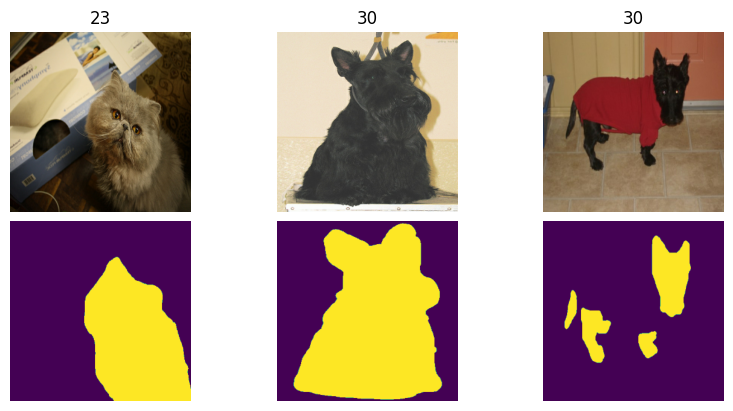

In [7]:
# lets plot a few now to see some good kittens/doggos
fig, axs = plt.subplots(2, 3, figsize=(8, 4), layout="constrained")
num_plot = 3
i = 0

# each sample of our dataset will be of the format
# image, outputs
# where outputs[0] = label
#       outputs[1] = segmentation mask
#
#
# lets get a single batch, and plot just a few of them
for image, output in train_class_seg.take(1).as_numpy_iterator(): 
    for i in range(num_plot): 
        im = axs[0, i].imshow(np.squeeze(unprocess_image(image[i, ...])) / 255.0)
        axs[0, i].set_title(output[0][i])
        axs[0, i].axis('off')
        im = axs[1, i].imshow(np.squeeze(output[1][i, ...]))
        axs[1, i].axis('off')
        
        print(output[1].shape)
        i += 1
        if i >= num_plot:
            break
        
plt.savefig('doggos_cattos.png')

The images are showing correctly.

**NOTE: You can ignore the JPEG wearning.**

We can use the ``classification`` and ``segmentation`` flags to pull out just one output as well, as the below demonstrates. 

In [8]:
# classification only; classification = True, segmentation = False (note batch size is 1 here)
train_class_only = load_oxford_pets1('train', classification=True, segmentation=False, shuffle=True, augment=True, batch_size=1, image_size=image_size)
# segmentation only; classification = False, segmentation = True (note batch size is 1 here)
train_seg_only = load_oxford_pets1('train', classification=False, segmentation=True, shuffle=True, augment=True, batch_size=1, image_size=image_size)

# test the classification only dataset
# pull out one element
inp, out = next(iter(train_class_only))
# print the output
print(out.numpy())

# test the segmentation only dataset
# pull out one element
inp, out = next(iter(train_seg_only))
# print just the output shape for the segmentation output 
print(out.numpy().shape)

[12]
(1, 300, 300, 1)


While for the question you do need to train networks to do both tasks simultaenously, when you starting playing with the problem it might be easier to get things working for one task, and then add the second.

### Loading MobileNetV3Small base for fine tuning

This model can be loaded directly from keras. By default, the model we download will be pre-trained on Imagenet dataset.

Note that we will need to set the preprocessing option when loading this base network to False. This is because the `include_preprocessing` step is implemented in the Datasets we defined above.

We also set `include_top=False`, to avoid loading our model with the final Dense classification layer which is used for the original Imagenet model.

More details are available in the keras documentation [here](https://keras.io/api/applications/mobilenet/).

In [9]:
mobile_base = keras.applications.MobileNetV3Small(input_shape=(image_size, image_size, 3),
                                                  include_top=False,
                                                  include_preprocessing=False)

/home/ethan/venvs/cab420_venv/lib/python3.12/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


For this task, can ignore the input_shape warning, though it is important to keep in mind the difference in size of data used for the pre-trained model and our data may have an impact on our model (what that impact might be is for you to investigate :) ). Depending on what input shape you select you may also be able to eliminate this.

For more information on fine-tuning models, can refer to many of the examples from class, or the [Keras documentation](https://keras.io/guides/transfer_learning/)

## Question 2 Template

The following provides a starting point for your solution, and some suggestions on how to proceed. 

**PLEASE READ THE COMMENTS CAREFULLY** There are a number of tips around how to proceed, and things to look out for.

In [10]:
#
# Data loading
#
# Use the provided data loader, setting your batch size and image size appropriately.
# Note that you may want to add more augmentation into the data loader.
# For initial experiments you may also want to turn one of classification or segmentation off to allow you to play with a single task.
# image_size = 300 # WARNING: THIS VALUE IS STUPID
# batch_size = 273 # WARNING: THIS VALUE IS STUPID
# # load training data, note that shuffle and augment are true
# train_class_seg = load_oxford_pets('train', classification=True, segmentation=True, shuffle=True, augment=True, 
#                                    batch_size=batch_size, image_size=image_size)
# # load validation data, note that shuffle and augment are false (though if they weren't, the data loader would force these to be false)
# val_class_seg = load_oxford_pets('val', classification=True, segmentation=True, shuffle=False, augment=False, 
#                                  batch_size=batch_size, image_size=image_size)
# # load testing data, note that shuffle and augment are false (though if they weren't, the data loader would force these to be false)
# test_class_seg = load_oxford_pets('test', classification=True, segmentation=True, shuffle=False, augment=False, 
#                                   batch_size=batch_size, image_size=image_size)

# Note that you may also want a non-shuffled version of the training set to help you evaluate training performance. You could simply create another
# training set object with the same settings, but shuffle set to False, i.e.
# train_class_seg_ns = load_oxford_pets('train', classification=True, segmentation=True, shuffle=False, augment=True, 
#                                       batch_size=batch_size, image_size=image_size)

In [11]:
# 
# From-scratch DCNN
#
# Put your from-scratch DCNN here. This network will have one input (the input image), and two outputs (the class, and the segmentation map). You can
# think of your model as having three components:
#  - A backbone, which is going to take your input and encode that. This will possibly be collection of (probably mostly) 2D convolution layers 
#    and max pooling layers (and for which you may be able to find something fairly fit for purpose in lecture or prac examples).
#  - A classification head, which will take the backbone output and via one or more dense layers do the classification task. This will likely only
#    be a few layers at most.
#  - A decoder head, which will do the semantic segmentation. This will look a lot like the back half of an autoencoder.
#
# As usual, the network does not need to be overly complex, but you will need to briefly explain your selection of this model, and you should avoid 
# networks so simple that they perform very badly.
#
# Take note of the order that the outputs appear in the data loader. The data loader will give you (classification_output, segmentation_output), so
# your network should have the outputs in the same order, and your losses should also be in the same order. With your losses, note that:
# * For the classification task ground truth data is being given as class labels, so you should use Sparse Categorical Cross Entropy.
# * For the segmentation loss, there are a few options you could use, but a good starting point is simply binary cross entropy, essentially
#   every pixel is a binary classification task (foreground or background)
# * The order of your losses is critical. The dataset object will give you (classification_targets, segmentation_targets). This means that you're 
#   network should it's outputs, and loss functions, in the same order - if you get this order wrong you will get weird errors
#
# When first developing your model, you may want to start by getting a single output of the network going, and then adding the second output. For
# example, you may build a network with the image input and the just the classification head, get that running, and then add the decoder head. You can
# use the classification and segmentation flags in the data loader to turn off one of the outputs.

# For model training, we have provided a callback, TrainForTime, which will terminate training after some time limit is reached. You could use this
# as follows:
#
#   train_time = 15 # 15-minute training limit
#   my_awesome_model.fit(train_class_seg, epochs=epochs, verbose=True, validation_data=val_class_seg, callbacks=[TrainForTime(train_time)])
#
# You don't have to use this, but you may wish to use this to ensure training doesn't take too long.
# Note that if you don't train until convergence, you will need to explain what you observe with training and what the implications of this are.

In [14]:
# -------------------------------
# Data Loading for Training & Evaluation
# -------------------------------
image_size = 256  # Use updated target size
batch_size = 32   # Moderate batch size

train_class_seg = load_oxford_pets2('train', classification=True, segmentation=True, shuffle=True, augment=True,  
                                    batch_size=batch_size, image_size=image_size)
val_class_seg   = load_oxford_pets2('val', classification=True, segmentation=True, shuffle=False, augment=False,  
                                    batch_size=batch_size, image_size=image_size)
test_class_seg  = load_oxford_pets2('test', classification=True, segmentation=True, shuffle=False, augment=False,  
                                    batch_size=batch_size, image_size=image_size)

# -------------------------------
# Build the From-Scratch DCNN Model
# -------------------------------
from tensorflow.keras import layers, models, Input

def build_dcnn_model(input_shape=(256, 256, 3), num_classes=37):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Backbone: 3 convolutional blocks.
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)  # 256 -> 128

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)  # 128 -> 64

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)  # 64 -> 32 (feature map size: 32x32)
    
    # Classification Head
    cls_branch = layers.GlobalAveragePooling2D()(x)
    cls_branch = layers.Dense(64, activation='relu')(cls_branch)
    classification_output = layers.Dense(num_classes, activation='softmax', name='classification')(cls_branch)
    
    # Segmentation Head (Decoder)
    seg_branch = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    seg_branch = layers.UpSampling2D((2, 2))(seg_branch)  # 32 -> 64
    seg_branch = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(seg_branch)
    seg_branch = layers.UpSampling2D((2, 2))(seg_branch)  # 64 -> 128
    seg_branch = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(seg_branch)
    seg_branch = layers.UpSampling2D((2, 2))(seg_branch)  # 128 -> 256
    seg_branch = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(seg_branch)
    segmentation_output = layers.Conv2D(1, (1, 1), activation='sigmoid', name='segmentation')(seg_branch)
    
    model = models.Model(inputs=inputs, outputs=[classification_output, segmentation_output], name='DCNN_from_scratch')
    return model

model_dcnn = build_dcnn_model(input_shape=(image_size, image_size, 3), num_classes=37)
model_dcnn.compile(optimizer='adam',
              loss={'classification': 'sparse_categorical_crossentropy',
                    'segmentation': 'binary_crossentropy'},
              metrics={'classification': 'accuracy',
                       'segmentation': 'accuracy'})
model_dcnn.summary()


# -------------------------------
# Training (example)
# -------------------------------
# You can train your model with a time-based callback to limit training time.
# Example:
#
# train_time = 15  # 15-minute training limit
# my_awesome_model.fit(train_class_seg, epochs=..., verbose=True,
#                      validation_data=val_class_seg,
#                      callbacks=[TrainForTime(train_time)])
#
# When initially developing, you might begin with a single output (classification only or segmentation only)
# by modifying the data loader flags, then add the second task once the first performs satisfactorily.


Model: "DCNN_from_scratch"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │    147,584 │ max_pooling2d_5[

 Total params: 543,942 (2.07 MB)

 Trainable params: 543,046 (2.07 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50


I0000 00:00:1746332955.411648   20246 service.cc:148] XLA service 0x7f7fa8002990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746332955.413218   20246 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
I0000 00:00:1746332955.829265   20246 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/115 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - classification_accuracy: 0.0547 - classification_loss: 3.7479 - loss: 4.7455 - segmentation_accuracy: 0.4493 - segmentation_loss: 0.9976 

I0000 00:00:1746332968.065236   20246 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/115 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - classification_accuracy: 0.0539 - classification_loss: 3.6090 - loss: 4.2520 - segmentation_accuracy: 0.6259 - segmentation_loss: 0.6430 - val_classification_accuracy: 0.0309 - val_classification_loss: 4.4417 - val_loss: 5.2296 - val_segmentation_accuracy: 0.5735 - val_segmentation_loss: 0.7861
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - classification_accuracy: 0.0978 - classification_loss: 3.3741 - loss: 3.9132 - segmentation_accuracy: 0.7240 - segmentation_loss: 0.5391 - val_classification_accuracy: 0.0245 - val_classification_loss: 4.9292 - val_loss: 5.6868 - val_segmentation_accuracy: 0.5767 - val_segmentation_loss: 0.7497
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - classification_accuracy: 0.1301 - classification_loss: 3.1725 - loss: 3.6763 - segmentation_accuracy: 0.7511 - segmentation_loss: 0.5039 - val_classification_accuracy: 0.0218 - val_classification_loss: 4.9182 - val_loss: 5.6452 - val_segmentation_acc

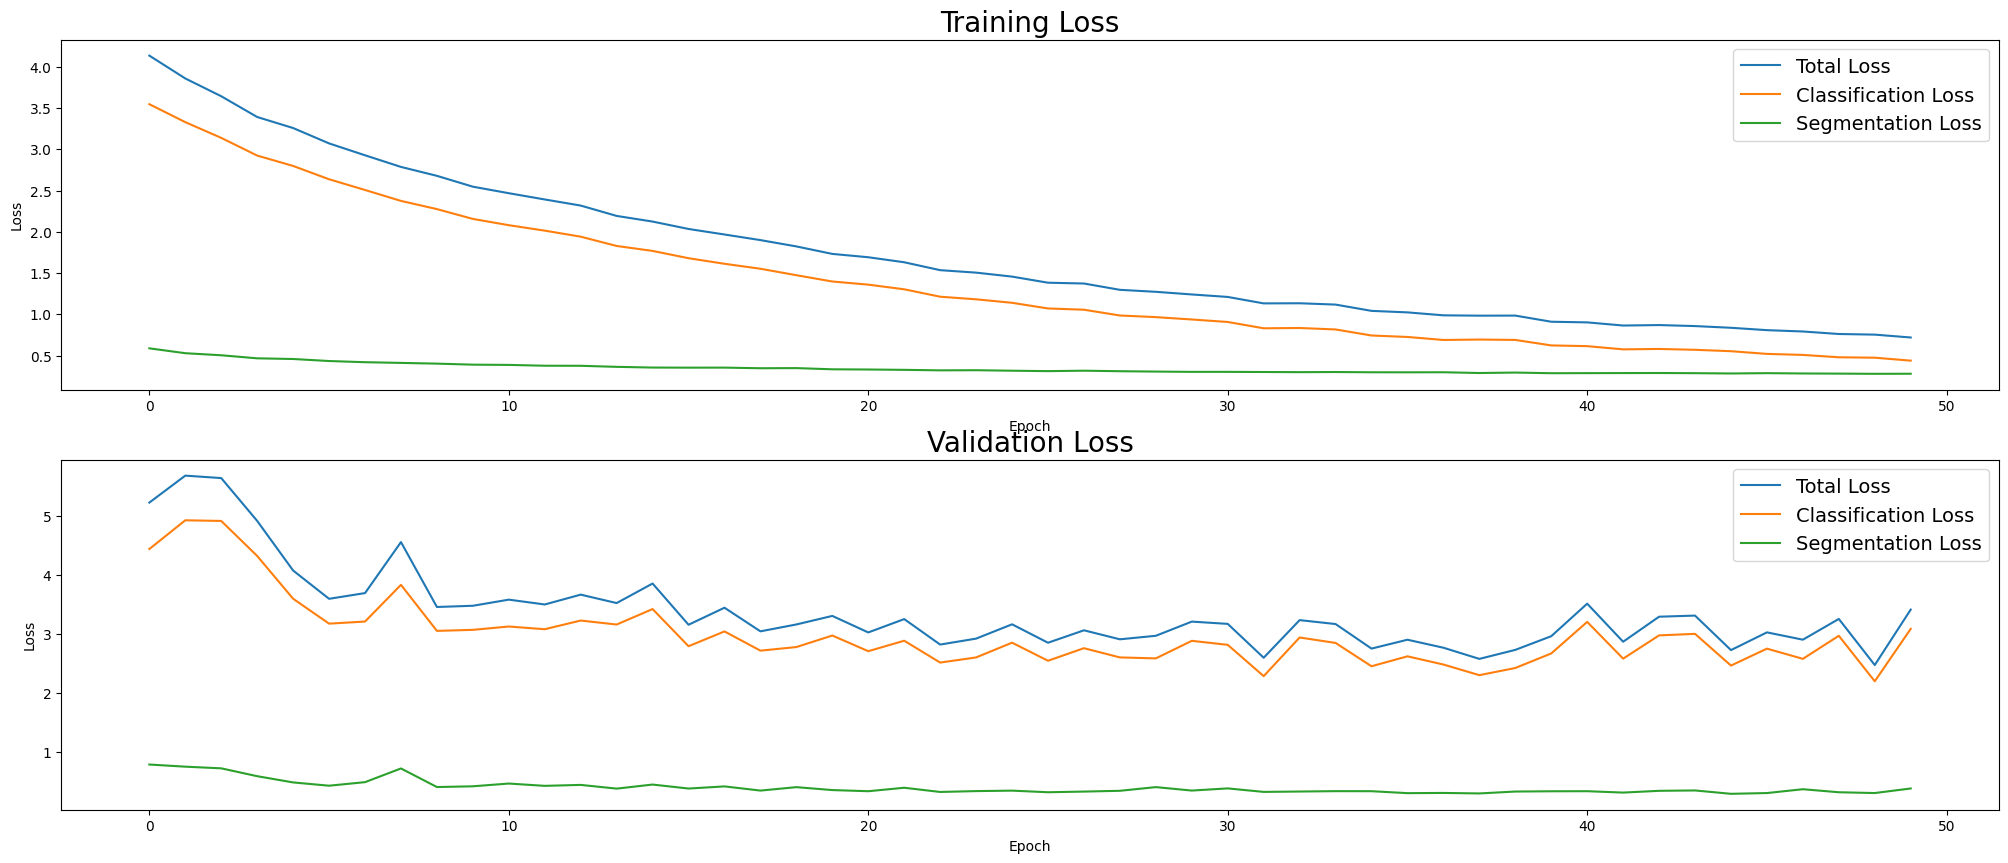

In [15]:
# -------------------------------
# Training
# -------------------------------
epochs = 50  # For example, train for 5 epochs.
train_time = 15  # 15-minute training limit
history_dcnn = model_dcnn.fit(train_class_seg, epochs=epochs, validation_data=val_class_seg, callbacks=[TrainForTime(train_time)])

fig = plt.figure(figsize=[25, 10])

# Training Loss Subplot
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history_dcnn.history['loss'], label='Total Loss')
ax1.plot(history_dcnn.history['classification_loss'], label='Classification Loss')
ax1.plot(history_dcnn.history['segmentation_loss'], label='Segmentation Loss')
ax1.set_title('Training Loss', fontsize=20)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(fontsize=14)
#ax1.grid(True)

# Validation Loss Subplot
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history_dcnn.history['val_loss'], label='Total Loss')
ax2.plot(history_dcnn.history['val_classification_loss'], label='Classification Loss')
ax2.plot(history_dcnn.history['val_segmentation_loss'], label='Segmentation Loss')
ax2.set_title('Validation Loss', fontsize=20)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(fontsize=14)
#ax2.grid(True)

plt.show()




81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step


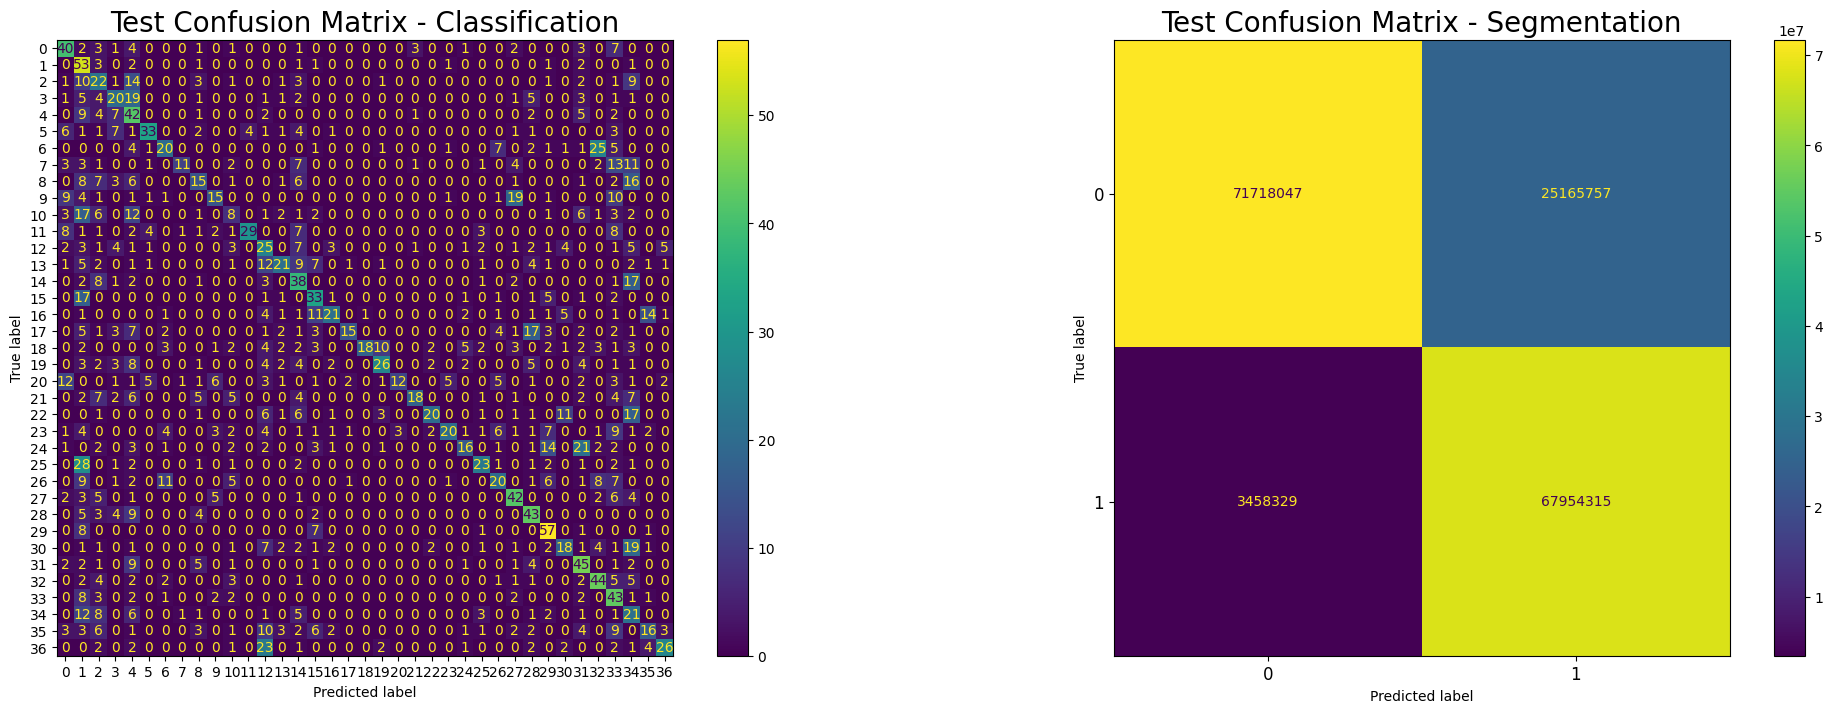


--- Classification Evaluation Metrics ---
Classification Accuracy: 38.51%
Classification Precision: 0.49
Classification Recall: 0.38
Classification F1 Score: 0.38

--- Segmentation Evaluation Metrics ---
Segmentation Accuracy: 82.99%
Segmentation Precision: 0.73
Segmentation Recall: 0.95
Segmentation F1 Score: 0.83


In [16]:
# -------------------------------
# Evaluation: Extract test ground-truth labels
y_class_test = np.concatenate([y[0] for x, y in test_class_seg.as_numpy_iterator()])
y_seg_test   = np.concatenate([y[1] for x, y in test_class_seg.as_numpy_iterator()])

# Obtain predictions on the test set
class_preds, seg_preds = model_dcnn.predict(test_class_seg)

# ----- Classification Evaluation -----
# Convert softmax outputs to predicted class labels.
pred_class = np.argmax(class_preds, axis=1)
classification_accuracy = np.mean(pred_class == y_class_test)
cm_class = confusion_matrix(y_class_test, pred_class)

# Compute additional metrics (using macro averaging for multiple classes)
classification_precision = sklearn.metrics.precision_score(y_class_test, pred_class, average='macro')
classification_recall = sklearn.metrics.recall_score(y_class_test, pred_class, average='macro')
classification_f1 = sklearn.metrics.f1_score(y_class_test, pred_class, average='macro')

# ----- Segmentation Evaluation -----
# The segmentation output is a per-pixel probability.
# Flatten predictions and ground truth, then threshold at 0.5.
seg_preds_flat = seg_preds.reshape(-1) > 0.5
seg_gt_flat    = y_seg_test.reshape(-1) > 0.5
cm_seg = confusion_matrix(seg_gt_flat, seg_preds_flat)
seg_accuracy = np.mean(seg_preds_flat == seg_gt_flat)
seg_precision = sklearn.metrics.precision_score(seg_gt_flat, seg_preds_flat)
seg_recall = sklearn.metrics.recall_score(seg_gt_flat, seg_preds_flat)
seg_f1 = sklearn.metrics.f1_score(seg_gt_flat, seg_preds_flat)

# -------------------------------
# Plot Both Confusion Matrices as Subplots
# -------------------------------
fig, axs = plt.subplots(1, 2, figsize=(25, 8))

# Plot classification confusion matrix
disp_class = ConfusionMatrixDisplay(confusion_matrix=cm_class)
disp_class.plot(ax=axs[0], values_format='d')
axs[0].set_title("Test Confusion Matrix - Classification", fontsize=20)
axs[0].tick_params(axis='x', labelsize=10)
axs[0].tick_params(axis='y', labelsize=10)

# Plot segmentation confusion matrix
disp_seg = ConfusionMatrixDisplay(confusion_matrix=cm_seg)
disp_seg.plot(ax=axs[1], values_format='d')
axs[1].set_title("Test Confusion Matrix - Segmentation", fontsize=20)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)

plt.show()

# -------------------------------
# Print Classification Metrics
# -------------------------------
print("\n--- Classification Evaluation Metrics ---")
print("Classification Accuracy: {:.2f}%".format(classification_accuracy * 100))
print("Classification Precision: {:.2f}".format(classification_precision))
print("Classification Recall: {:.2f}".format(classification_recall))
print("Classification F1 Score: {:.2f}".format(classification_f1))

# -------------------------------
# Print Segmentation Metrics
# -------------------------------
print("\n--- Segmentation Evaluation Metrics ---")
print("Segmentation Accuracy: {:.2f}%".format(seg_accuracy * 100))
print("Segmentation Precision: {:.2f}".format(seg_precision))
print("Segmentation Recall: {:.2f}".format(seg_recall))
print("Segmentation F1 Score: {:.2f}".format(seg_f1))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


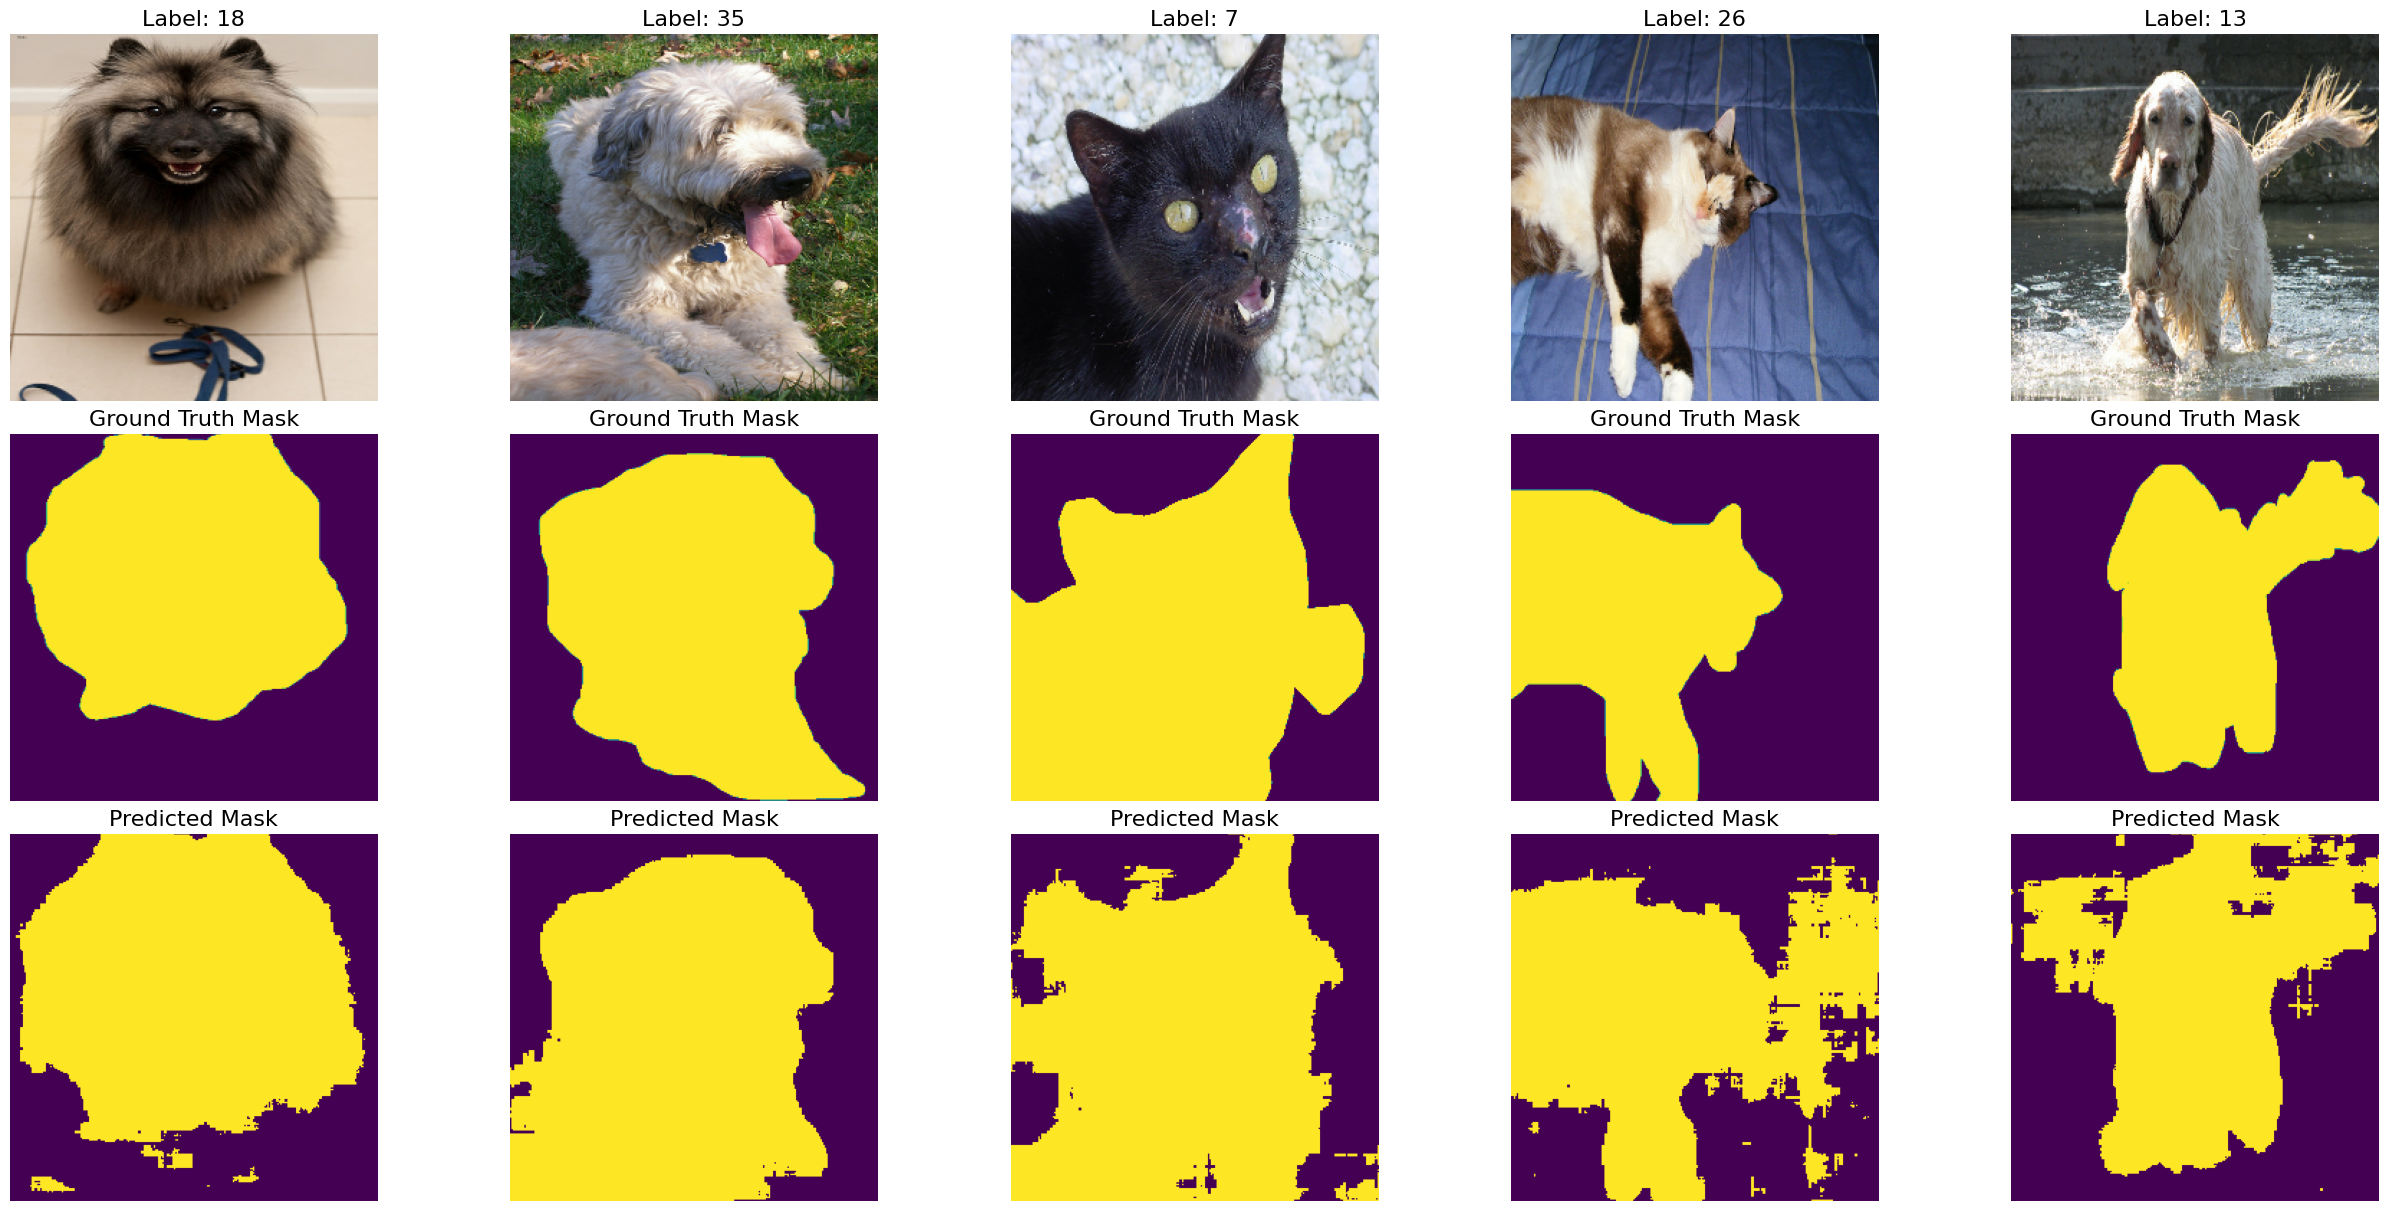

In [26]:
num_plot = 5  # number of samples to display

# Get a single batch from the training dataset and compute model predictions.
for images, outputs in test_class_seg.take(1).as_numpy_iterator():
    # Compute model predictions (assume the model returns a tuple: [classification, segmentation])
    preds = model_dcnn.predict(images)
    # Extract predicted segmentation masks (second output) and optionally threshold them
    pred_seg = preds[1]  # raw segmentation probabilities

    # Create a 3-row, num_plot-col subplot.
    fig, axs = plt.subplots(3, num_plot, figsize=(25, 12), layout="constrained")
    
    for i in range(num_plot):
        # Row 0: Original image (unprocessed for display) with the ground truth label as title.
        image_disp = np.squeeze(unprocess_image(images[i])) / 255.0  # revert preprocessing
        axs[0, i].imshow(image_disp)
        axs[0, i].set_title(f"Label: {outputs[0][i]}", fontsize=16)
        axs[0, i].axis('off')
        
        # Row 1: Ground-truth segmentation mask.
        axs[1, i].imshow(np.squeeze(outputs[1][i]))
        axs[1, i].set_title("Ground Truth Mask", fontsize=16)
        axs[1, i].axis('off')
        
        # Row 2: Predicted segmentation mask.
        # Here, threshold the predictions at 0.5 so that true is foreground.
        pred_mask = (np.squeeze(pred_seg[i]) > 0.5).astype(np.uint8)
        axs[2, i].imshow(pred_mask) #, cmap='gray'
        axs[2, i].set_title("Predicted Mask", fontsize=16)
        axs[2, i].axis('off')
    
    plt.savefig('doggos_cattos_with_pred_mask.png')
    plt.show()


In [12]:
# -------------------------------
# Data Loading for Training & Evaluation
# -------------------------------
image_size = 256  # Use updated target size
batch_size = 32   # Moderate batch size

train_class_seg = load_oxford_pets2('train', classification=True, segmentation=True, shuffle=True, augment=True,  
                                    batch_size=batch_size, image_size=image_size)
val_class_seg   = load_oxford_pets2('val', classification=True, segmentation=True, shuffle=False, augment=False,  
                                    batch_size=batch_size, image_size=image_size)
test_class_seg  = load_oxford_pets2('test', classification=True, segmentation=True, shuffle=False, augment=False,  
                                    batch_size=batch_size, image_size=image_size)

# -------------------------------
# Build the From-Scratch DCNN Model
# -------------------------------
from tensorflow.keras import layers, models, Input

def build_dcnn_model_2(input_shape=(256, 256, 3), num_classes=37):
    inputs = Input(shape=input_shape)
    
    # Backbone: 3 convolutional blocks
    # Block 1: 256 -> 128
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)  # 256 -> 128

    # Block 2: 128 -> 64
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)  # 128 -> 64

    # Block 3: 64 -> 32
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)  # 64 -> 32
    
    # Additional Pooling to reduce from 32x32 to 8x8:
    x = layers.MaxPooling2D((2, 2))(x)  # 32 -> 16
    x = layers.MaxPooling2D((2, 2))(x)  # 16 -> 8

    # Classification Head
    cls_branch = layers.GlobalAveragePooling2D()(x)
    cls_branch = layers.Dense(64, activation='relu')(cls_branch)
    classification_output = layers.Dense(num_classes, activation='softmax', name='classification')(cls_branch)
    
    # Segmentation Head (MobileNet Style Decoder)
    # Starting with a feature map of 8x8, we'll use five upsampling steps to get to 256x256.
    seg_branch = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)  # from 8x8 remains 8x8
    seg_branch = layers.UpSampling2D((2, 2))(seg_branch)  # 8x8 -> 16x16
    seg_branch = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(seg_branch)
    seg_branch = layers.UpSampling2D((2, 2))(seg_branch)  # 16x16 -> 32x32
    seg_branch = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(seg_branch)
    seg_branch = layers.UpSampling2D((2, 2))(seg_branch)  # 32x32 -> 64x64
    seg_branch = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(seg_branch)
    seg_branch = layers.UpSampling2D((2, 2))(seg_branch)  # 64x64 -> 128x128
    seg_branch = layers.UpSampling2D((2, 2))(seg_branch)  # 128x128 -> 256x256
    segmentation_output = layers.Conv2D(1, (1, 1), activation='sigmoid', name='segmentation')(seg_branch)
    
    model = models.Model(inputs=inputs, outputs=[classification_output, segmentation_output], name='DCNN_from_scratch_modified')
    return model


model_dcnn_2 = build_dcnn_model_2(input_shape=(image_size, image_size, 3), num_classes=37)
model_dcnn_2.compile(optimizer='adam',
              loss={'classification': 'sparse_categorical_crossentropy',
                    'segmentation': 'binary_crossentropy'},
              metrics={'classification': 'accuracy',
                       'segmentation': 'accuracy'})
model_dcnn_2.summary()

Model: "DCNN_from_scratch_modified"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ max_pooling2d_2[

 Total params: 543,942 (2.07 MB)

 Trainable params: 543,046 (2.07 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50


I0000 00:00:1746338547.245129   24152 service.cc:148] XLA service 0x7f8d240028c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746338547.245459   24152 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
I0000 00:00:1746338547.690922   24152 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/115 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - classification_accuracy: 0.0469 - classification_loss: 4.8343 - loss: 5.5725 - segmentation_accuracy: 0.5103 - segmentation_loss: 0.7382  

I0000 00:00:1746338558.252736   24152 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/115 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - classification_accuracy: 0.0632 - classification_loss: 3.6676 - loss: 4.3077 - segmentation_accuracy: 0.6619 - segmentation_loss: 0.6401 - val_classification_accuracy: 0.0272 - val_classification_loss: 4.0762 - val_loss: 4.8270 - val_segmentation_accuracy: 0.5767 - val_segmentation_loss: 0.7521
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - classification_accuracy: 0.1085 - classification_loss: 3.2943 - loss: 3.8034 - segmentation_accuracy: 0.7446 - segmentation_loss: 0.5091 - val_classification_accuracy: 0.0318 - val_classification_loss: 5.2422 - val_loss: 5.7811 - val_segmentation_accuracy: 0.7176 - val_segmentation_loss: 0.5403
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - classification_accuracy: 0.1449 - classification_loss: 3.1003 - loss: 3.5708 - segmentation_accuracy: 0.7698 - segmentation_loss: 0.4705 - val_classification_accuracy: 0.0245 - val_classification_loss: 5.9046 - val_loss: 6.4183 - val_segmentation_acc

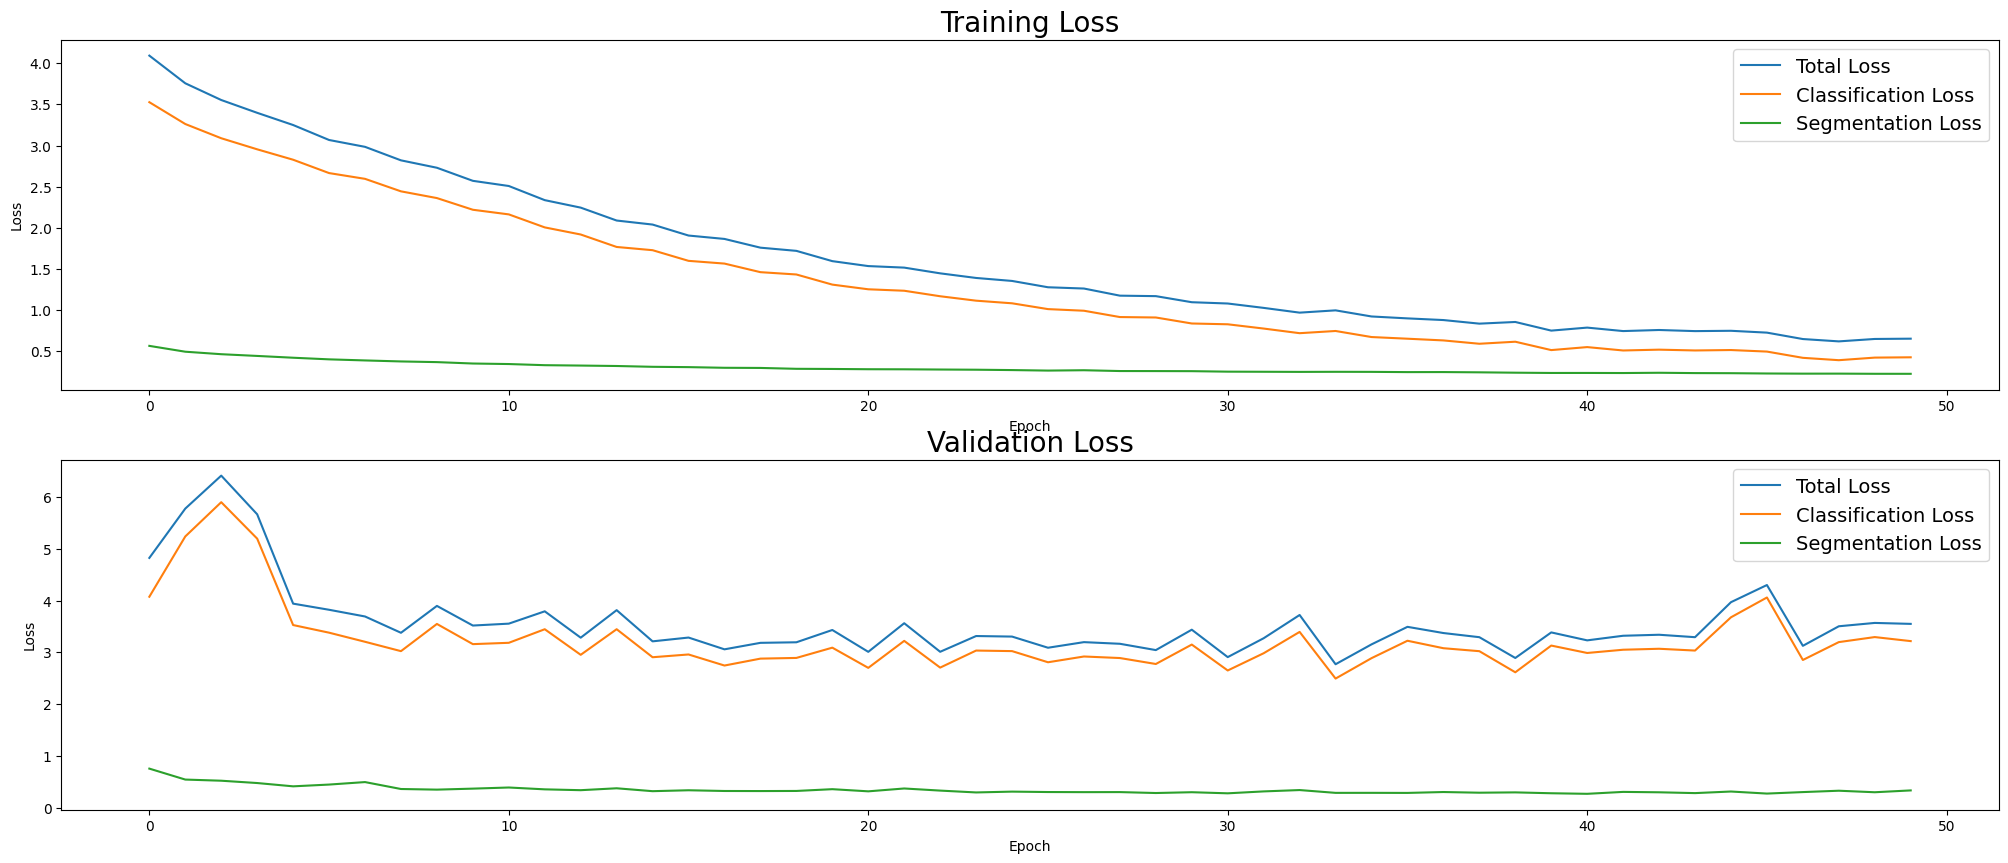

In [13]:
# -------------------------------
# Training
# -------------------------------
epochs = 50  # For example, train for 5 epochs.
train_time = 15  # 15-minute training limit
history_dcnn_2 = model_dcnn_2.fit(train_class_seg, epochs=epochs, validation_data=val_class_seg, callbacks=[TrainForTime(train_time)])

fig = plt.figure(figsize=[25, 10])

# Training Loss Subplot
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history_dcnn_2.history['loss'], label='Total Loss')
ax1.plot(history_dcnn_2.history['classification_loss'], label='Classification Loss')
ax1.plot(history_dcnn_2.history['segmentation_loss'], label='Segmentation Loss')
ax1.set_title('Training Loss', fontsize=20)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(fontsize=14)
#ax1.grid(True)

# Validation Loss Subplot
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history_dcnn_2.history['val_loss'], label='Total Loss')
ax2.plot(history_dcnn_2.history['val_classification_loss'], label='Classification Loss')
ax2.plot(history_dcnn_2.history['val_segmentation_loss'], label='Segmentation Loss')
ax2.set_title('Validation Loss', fontsize=20)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(fontsize=14)
#ax2.grid(True)

plt.show()

81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step  


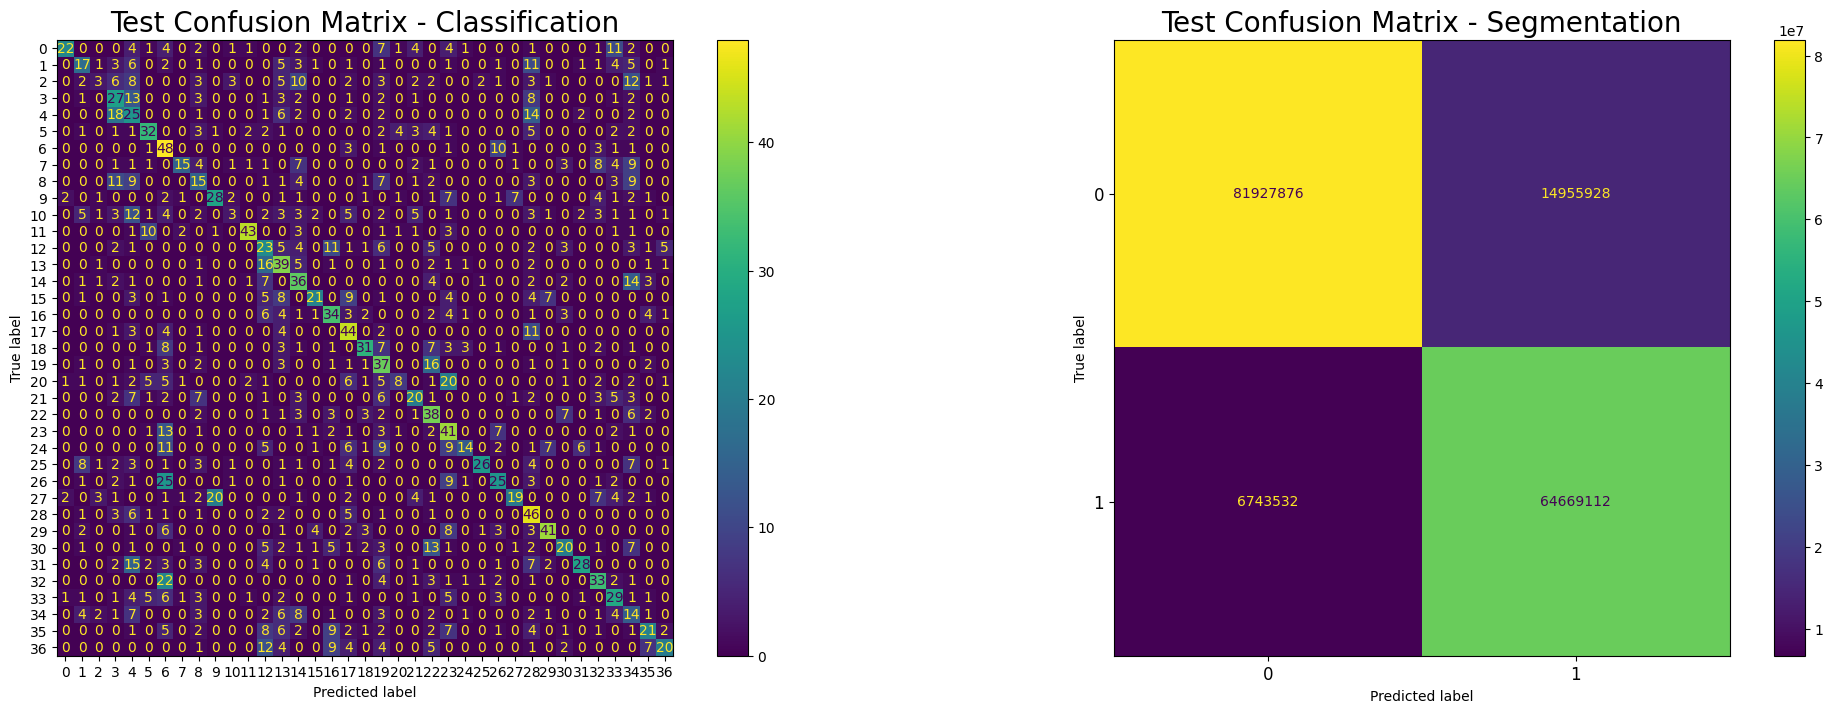


--- Classification Evaluation Metrics ---
Classification Accuracy: 38.40%
Classification Precision: 0.45
Classification Recall: 0.38
Classification F1 Score: 0.38

--- Segmentation Evaluation Metrics ---
Segmentation Accuracy: 87.11%
Segmentation Precision: 0.81
Segmentation Recall: 0.91
Segmentation F1 Score: 0.86


In [14]:
# -------------------------------
# Evaluation: Extract test ground-truth labels
y_class_test = np.concatenate([y[0] for x, y in test_class_seg.as_numpy_iterator()])
y_seg_test   = np.concatenate([y[1] for x, y in test_class_seg.as_numpy_iterator()])

# Obtain predictions on the test set
class_preds, seg_preds = model_dcnn_2.predict(test_class_seg)

# ----- Classification Evaluation -----
# Convert softmax outputs to predicted class labels.
pred_class = np.argmax(class_preds, axis=1)
classification_accuracy = np.mean(pred_class == y_class_test)
cm_class = confusion_matrix(y_class_test, pred_class)

# Compute additional metrics (using macro averaging for multiple classes)
classification_precision = sklearn.metrics.precision_score(y_class_test, pred_class, average='macro')
classification_recall = sklearn.metrics.recall_score(y_class_test, pred_class, average='macro')
classification_f1 = sklearn.metrics.f1_score(y_class_test, pred_class, average='macro')

# ----- Segmentation Evaluation -----
# The segmentation output is a per-pixel probability.
# Flatten predictions and ground truth, then threshold at 0.5.
seg_preds_flat = seg_preds.reshape(-1) > 0.5
seg_gt_flat    = y_seg_test.reshape(-1) > 0.5
cm_seg = confusion_matrix(seg_gt_flat, seg_preds_flat)
seg_accuracy = np.mean(seg_preds_flat == seg_gt_flat)
seg_precision = sklearn.metrics.precision_score(seg_gt_flat, seg_preds_flat)
seg_recall = sklearn.metrics.recall_score(seg_gt_flat, seg_preds_flat)
seg_f1 = sklearn.metrics.f1_score(seg_gt_flat, seg_preds_flat)

# -------------------------------
# Plot Both Confusion Matrices as Subplots
# -------------------------------
fig, axs = plt.subplots(1, 2, figsize=(25, 8))

# Plot classification confusion matrix
disp_class = ConfusionMatrixDisplay(confusion_matrix=cm_class)
disp_class.plot(ax=axs[0], values_format='d')
axs[0].set_title("Test Confusion Matrix - Classification", fontsize=20)
axs[0].tick_params(axis='x', labelsize=10)
axs[0].tick_params(axis='y', labelsize=10)

# Plot segmentation confusion matrix
disp_seg = ConfusionMatrixDisplay(confusion_matrix=cm_seg)
disp_seg.plot(ax=axs[1], values_format='d')
axs[1].set_title("Test Confusion Matrix - Segmentation", fontsize=20)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)

plt.show()

# -------------------------------
# Print Classification Metrics
# -------------------------------
print("\n--- Classification Evaluation Metrics ---")
print("Classification Accuracy: {:.2f}%".format(classification_accuracy * 100))
print("Classification Precision: {:.2f}".format(classification_precision))
print("Classification Recall: {:.2f}".format(classification_recall))
print("Classification F1 Score: {:.2f}".format(classification_f1))

# -------------------------------
# Print Segmentation Metrics
# -------------------------------
print("\n--- Segmentation Evaluation Metrics ---")
print("Segmentation Accuracy: {:.2f}%".format(seg_accuracy * 100))
print("Segmentation Precision: {:.2f}".format(seg_precision))
print("Segmentation Recall: {:.2f}".format(seg_recall))
print("Segmentation F1 Score: {:.2f}".format(seg_f1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


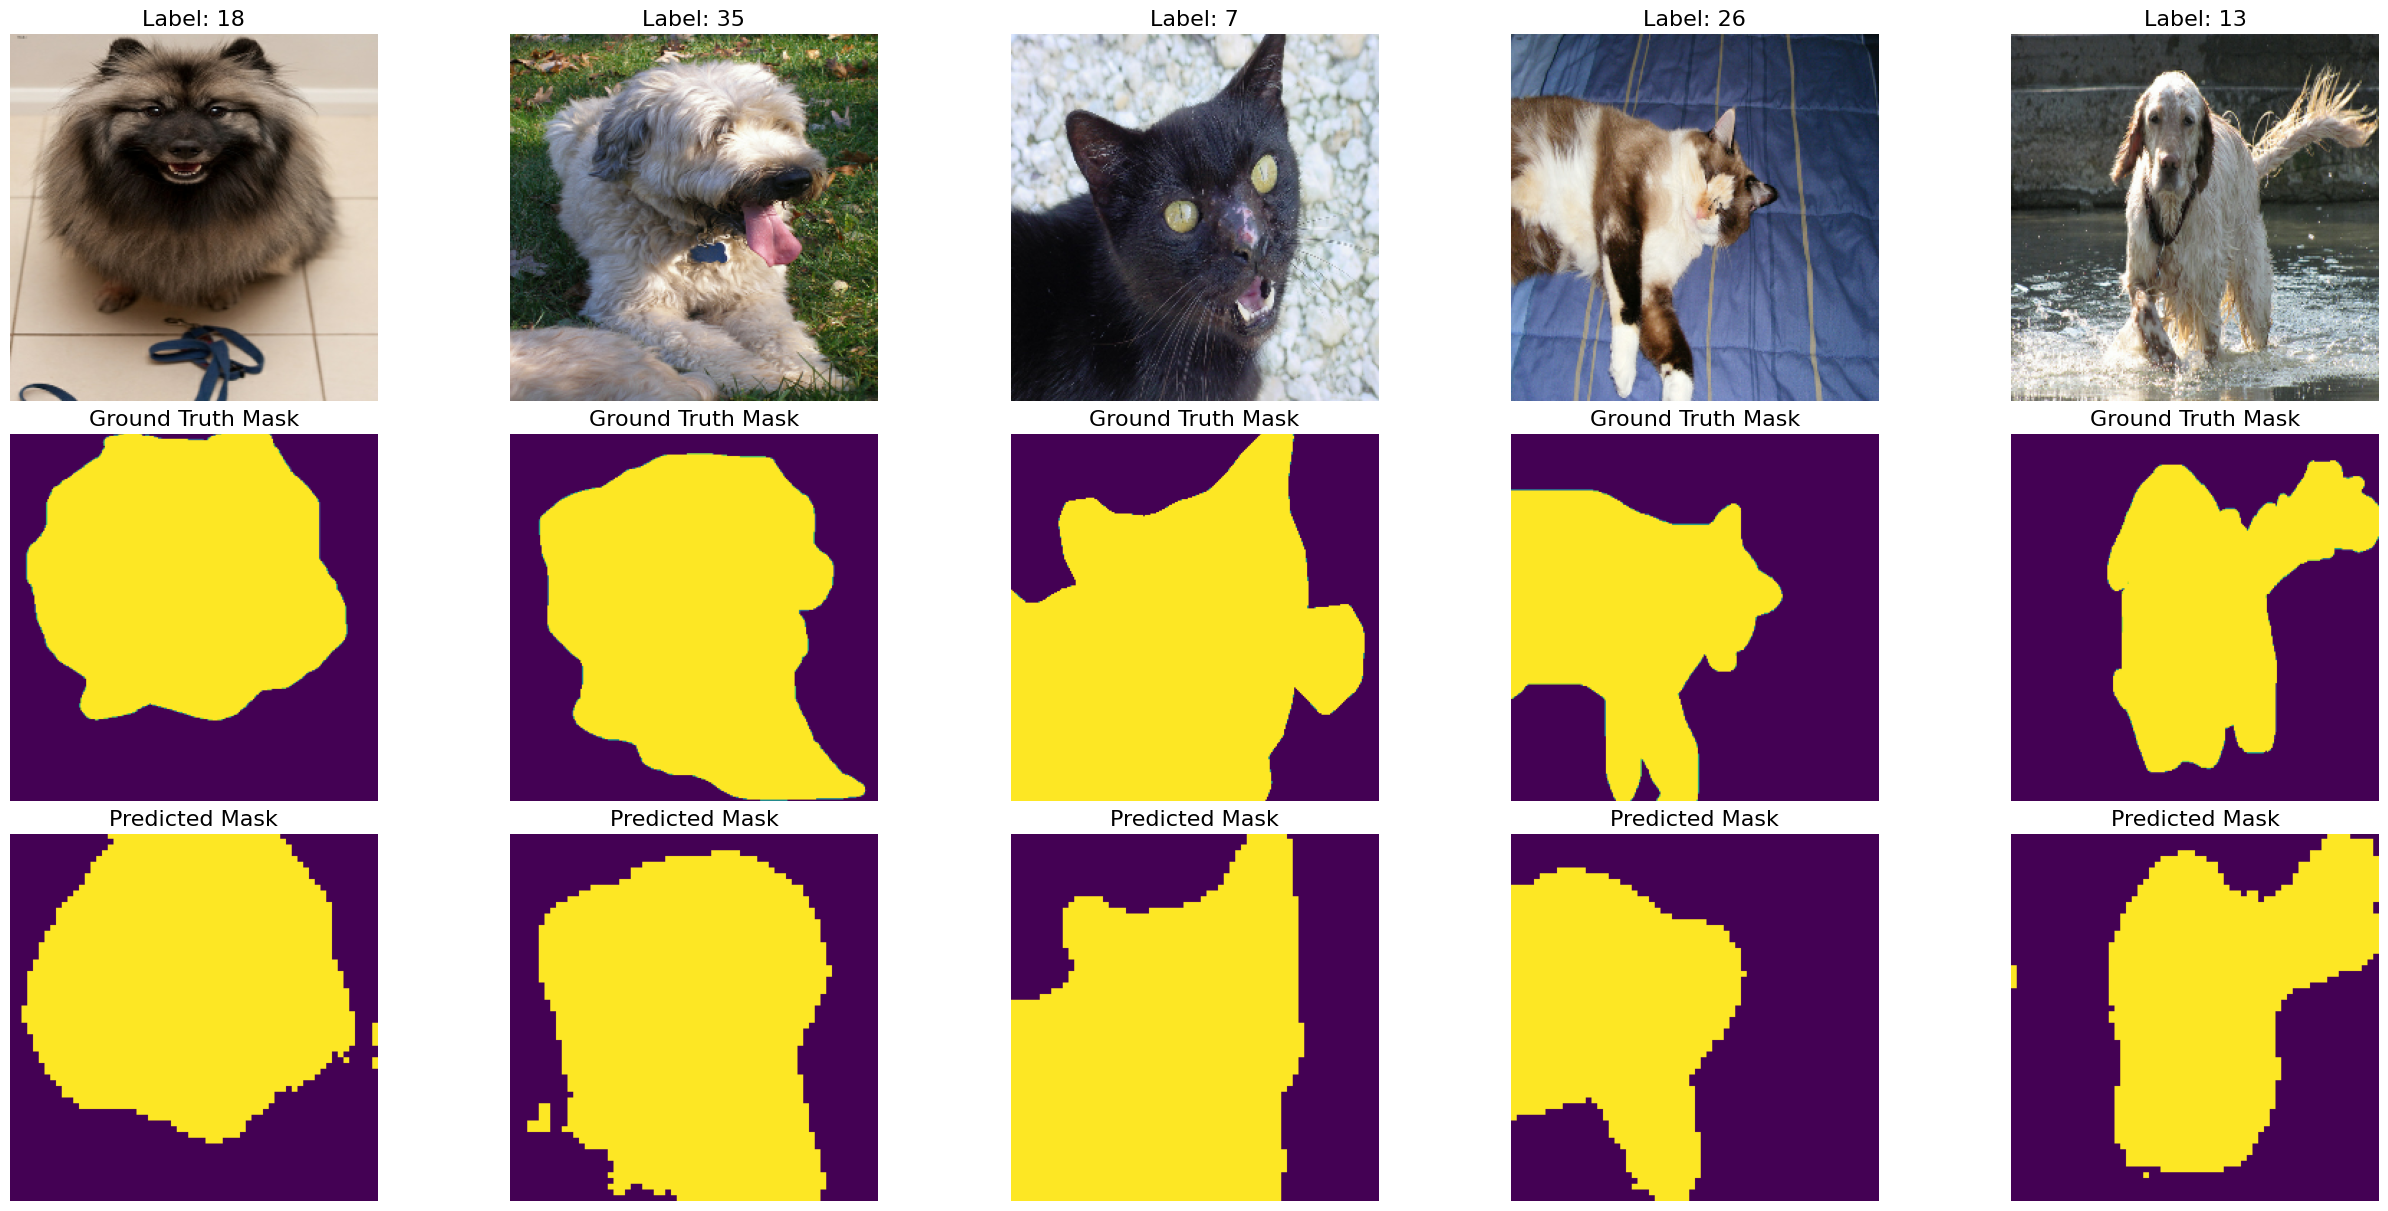

In [15]:
num_plot = 5  # number of samples to display

# Get a single batch from the training dataset and compute model predictions.
for images, outputs in test_class_seg.take(1).as_numpy_iterator():
    # Compute model predictions (assume the model returns a tuple: [classification, segmentation])
    preds = model_dcnn_2.predict(images)
    # Extract predicted segmentation masks (second output) and optionally threshold them
    pred_seg = preds[1]  # raw segmentation probabilities

    # Create a 3-row, num_plot-col subplot.
    fig, axs = plt.subplots(3, num_plot, figsize=(25, 12), layout="constrained")
    
    for i in range(num_plot):
        # Row 0: Original image (unprocessed for display) with the ground truth label as title.
        image_disp = np.squeeze(unprocess_image(images[i])) / 255.0  # revert preprocessing
        axs[0, i].imshow(image_disp)
        axs[0, i].set_title(f"Label: {outputs[0][i]}", fontsize=16)
        axs[0, i].axis('off')
        
        # Row 1: Ground-truth segmentation mask.
        axs[1, i].imshow(np.squeeze(outputs[1][i]))
        axs[1, i].set_title("Ground Truth Mask", fontsize=16)
        axs[1, i].axis('off')
        
        # Row 2: Predicted segmentation mask.
        # Here, threshold the predictions at 0.5 so that true is foreground.
        pred_mask = (np.squeeze(pred_seg[i]) > 0.5).astype(np.uint8)
        axs[2, i].imshow(pred_mask) #, cmap='gray'
        axs[2, i].set_title("Predicted Mask", fontsize=16)
        axs[2, i].axis('off')
    
    plt.savefig('doggos_cattos_with_pred_mask.png')
    plt.show()

In [18]:
#
# Fine-tuned MobileNet
#
# Pur your mobilenet model here. This will have the same structure as the from-scratch network above, but now the backbone will be mobilenet rather
# than something of your own design. The classification and segmentation heads will possibly be quite similar to what you have above. As per the 
# from-scratch network, you may want to build this with just one output to start with, and then add the second when you get that working.

# load mobilenet backbone
mobile_base = keras.applications.MobileNetV3Small(input_shape=(image_size, image_size, 3),
                                                  include_top=False,
                                                  include_preprocessing=False)
# build the rest of the model here

# train the model. As per the from-scratch model, you may wish to use the callback - though if the model is not trained until convergence you will
# need to explain the implications of this.

/home/ethan/venvs/cab420_venv/lib/python3.12/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "MobileNet_FineTuned"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobileNetV3Small    │ (None, 8, 8, 576) │    939,120 │ input_layer_5[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 8, 8, 128) │    663,680 │ MobileNetV3Small… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_6     │ (None, 16, 16,    │          0 │ conv2d_20[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │     73,792 │ up_sampling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_7     │ (None, 32, 32,    │          0 │ conv2d_21[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │     18,464 │ up_sampling2d_7[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_8     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │      4,624 │ up_sampling2d_8[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 576)       │          0 │ MobileNetV3Small… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_9     │ (None, 128, 128,  │          0 │ conv2d_23[0][0]   │
│ (UpSampling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     36,928 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_10    │ (None, 256, 256,  │          0 │ up_sampling2d_9[… │
│ (UpSampling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 37)        │      2,405 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segmentation        │ (None, 256, 256,  │         17 │ up_sampling2d_10… │
│ (Conv2D)            │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,739,030 (6.63 MB)

 Trainable params: 799,910 (3.05 MB)

 Non-trainable params: 939,120 (3.58 MB)

Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - classification_accuracy: 0.2428 - classification_loss: 2.9626 - loss: 3.3037 - segmentation_accuracy: 0.8359 - segmentation_loss: 0.3411 - val_classification_accuracy: 0.6649 - val_classification_loss: 1.2318 - val_loss: 1.4546 - val_segmentation_accuracy: 0.9127 - val_segmentation_loss: 0.2176
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - classification_accuracy: 0.7738 - classification_loss: 0.8621 - loss: 1.0420 - segmentation_accuracy: 0.9221 - segmentation_loss: 0.1799 - val_classification_accuracy: 0.7502 - val_classification_loss: 0.8067 - val_loss: 0.9944 - val_segmentation_accuracy: 0.9222 - val_segmentation_loss: 0.1872
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - classification_accuracy: 0.8511 - classification_loss: 0.5470 - loss: 0.7136 - segmentation_accuracy: 0.9263 - segmentation_loss: 0.1665 - val_classification_accuracy: 0.7884 - val_classification_loss: 0.6869 - val_loss: 0.8937 - val_segmenta

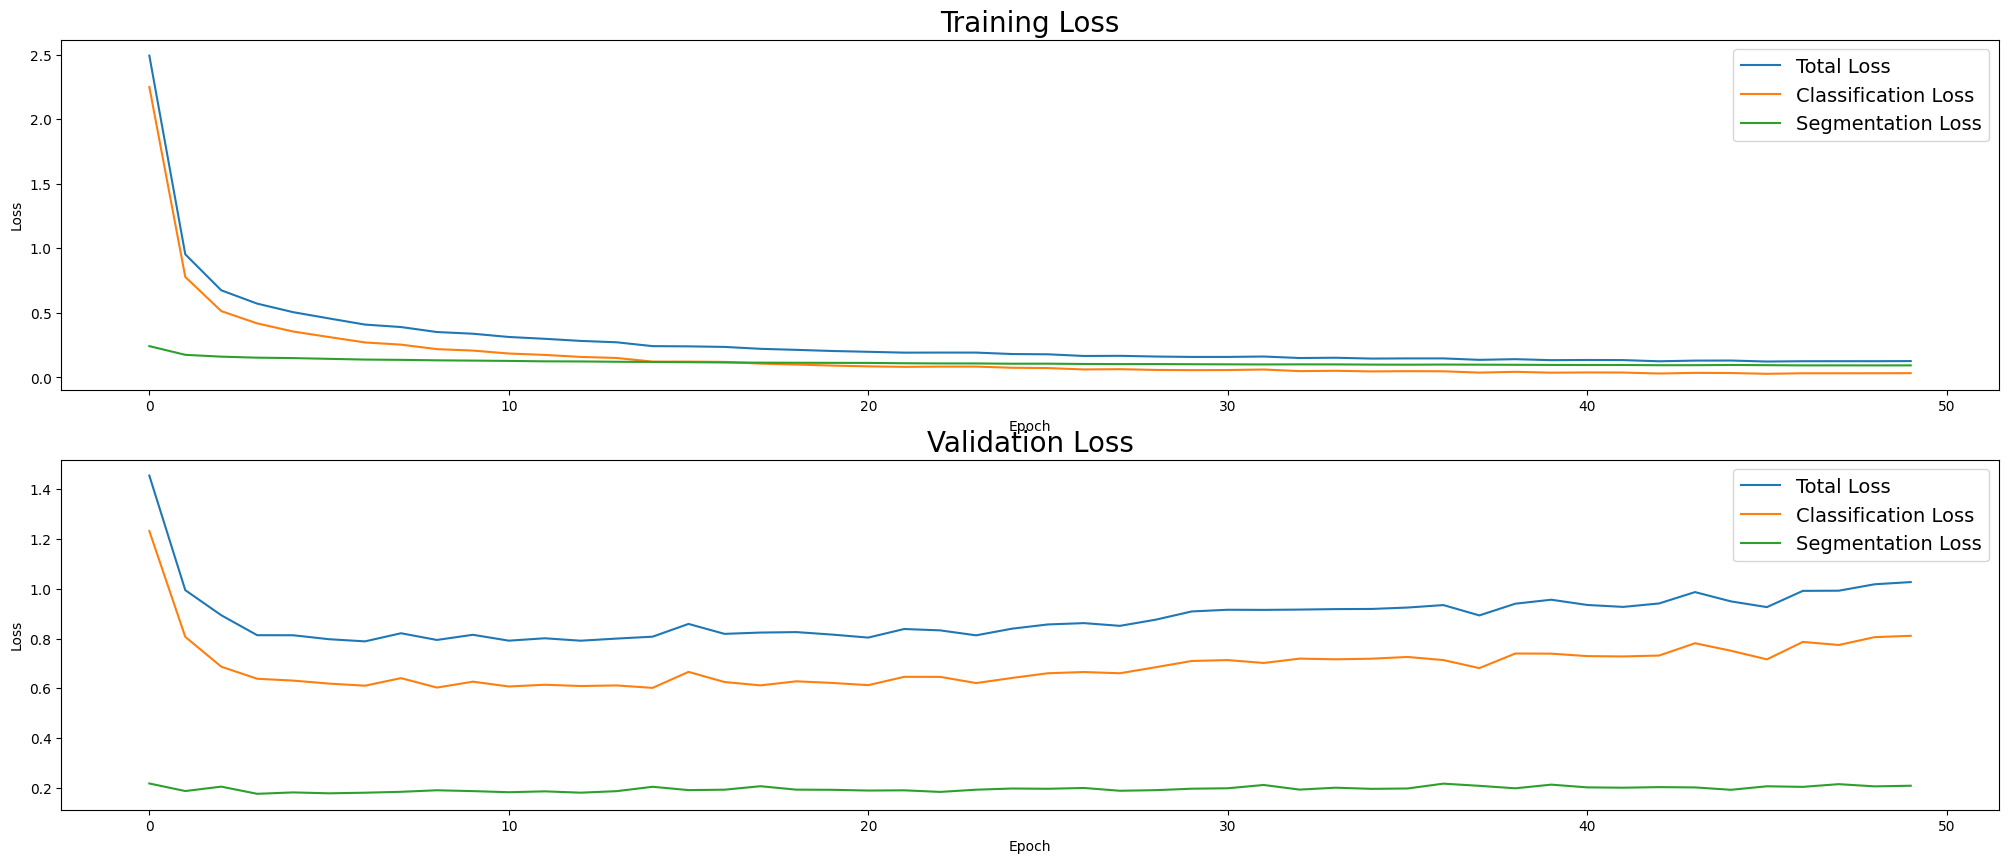

81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step


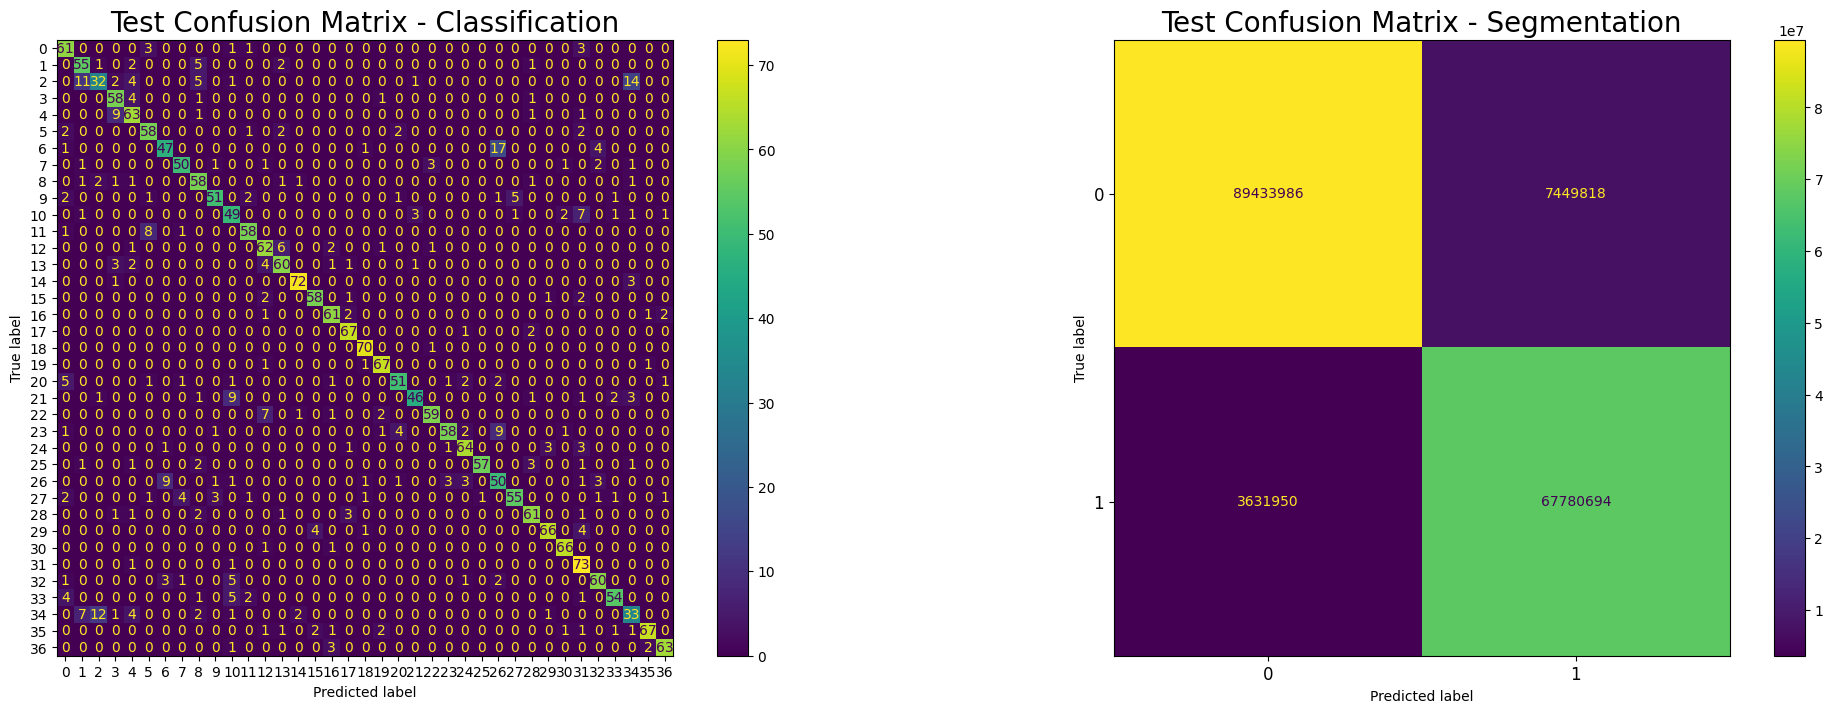


--- Classification Evaluation Metrics ---
Classification Accuracy: 83.33%
Classification Precision: 0.84
Classification Recall: 0.83
Classification F1 Score: 0.83

--- Segmentation Evaluation Metrics ---
Segmentation Accuracy: 93.42%
Segmentation Precision: 0.90
Segmentation Recall: 0.95
Segmentation F1 Score: 0.92


In [19]:
# -------------------------------
# Data Loading for Training & Evaluation
# -------------------------------
image_size = 256  # Use updated target size
batch_size = 32   # Moderate batch size

train_class_seg = load_oxford_pets2('train', classification=True, segmentation=True, 
                                    shuffle=True, augment=True,  
                                    batch_size=batch_size, image_size=image_size)
val_class_seg   = load_oxford_pets2('val', classification=True, segmentation=True, 
                                    shuffle=False, augment=False,  
                                    batch_size=batch_size, image_size=image_size)
test_class_seg  = load_oxford_pets2('test', classification=True, segmentation=True, 
                                    shuffle=False, augment=False,  
                                    batch_size=batch_size, image_size=image_size)

# -------------------------------
# Build the Fine-tuned MobileNet Model
# -------------------------------
def build_mobilenet_model(input_shape=(256, 256, 3), num_classes=37):
    # Load MobileNetV3Small backbone with no top layers.
    mobile_base = keras.applications.MobileNetV3Small(input_shape=input_shape, 
                                                       include_top=False, 
                                                       include_preprocessing=False)
    # Optionally freeze the backbone for initial training.
    for layer in mobile_base.layers:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    x = mobile_base(inputs)   # Suppose x has shape (None,8,8,?)  for 256x256 inputs
    
    # --- Classification Head ---
    cls_branch = layers.GlobalAveragePooling2D()(x)
    cls_branch = layers.Dense(64, activation='relu')(cls_branch)
    classification_output = layers.Dense(num_classes, activation='softmax', name='classification')(cls_branch)
    
    # --- Segmentation Head (Decoder) ---
    # We need to upsample from the backbone’s feature map (e.g. 8x8) to 256x256.
    # We'll perform five UpSampling2D steps (factor 2 each) so that 8->16->32->64->128->256.
    seg_branch = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)  # (8,8)->(8,8)
    seg_branch = layers.UpSampling2D((2, 2))(seg_branch)  # 8x8 -> 16x16
    seg_branch = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(seg_branch)
    seg_branch = layers.UpSampling2D((2, 2))(seg_branch)  # 16x16 -> 32x32
    seg_branch = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(seg_branch)
    seg_branch = layers.UpSampling2D((2, 2))(seg_branch)  # 32x32 -> 64x64
    seg_branch = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(seg_branch)
    seg_branch = layers.UpSampling2D((2, 2))(seg_branch)  # 64x64 -> 128x128
    seg_branch = layers.UpSampling2D((2, 2))(seg_branch)  # 128x128 -> 256x256
    segmentation_output = layers.Conv2D(1, (1, 1), activation='sigmoid', name='segmentation')(seg_branch)
    
    model = models.Model(inputs=inputs, outputs=[classification_output, segmentation_output],
                         name='MobileNet_FineTuned')
    return model

model_mobilenet = build_mobilenet_model(input_shape=(image_size, image_size, 3), num_classes=37)
model_mobilenet.compile(optimizer='adam',
              loss={'classification': 'sparse_categorical_crossentropy',
                    'segmentation': 'binary_crossentropy'},
              metrics={'classification': 'accuracy',
                       'segmentation': 'accuracy'})

model_mobilenet.summary()

train_time = 15  # 15-minute training limit
epochs = 50      # Up to 50 epochs (training may stop early due to time limit)

# -------------------------------
# Training
# -------------------------------
history_mobilenet = model_mobilenet.fit(train_class_seg, 
                    epochs=epochs,
                    validation_data=val_class_seg,
                    callbacks=[TrainForTime(train_time)],
                    verbose=True)

# -------------------------------
# Plot Training and Validation Loss
# -------------------------------

fig = plt.figure(figsize=(25, 10))

# Training Loss Subplot
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history_mobilenet.history['loss'], label='Total Loss')
ax1.plot(history_mobilenet.history['classification_loss'], label='Classification Loss')
ax1.plot(history_mobilenet.history['segmentation_loss'], label='Segmentation Loss')
ax1.set_title('Training Loss', fontsize=20)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(fontsize=14)
#ax1.grid(True)

# Validation Loss Subplot
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history_mobilenet.history['val_loss'], label='Total Loss')
ax2.plot(history_mobilenet.history['val_classification_loss'], label='Classification Loss')
ax2.plot(history_mobilenet.history['val_segmentation_loss'], label='Segmentation Loss')
ax2.set_title('Validation Loss', fontsize=20)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(fontsize=14)
#ax2.grid(True)

#plt.tight_layout()
plt.show()

# -------------------------------
# Evaluation
# -------------------------------
# Extract test ground-truth labels
y_class_test = np.concatenate([y[0] for x, y in test_class_seg.as_numpy_iterator()])
y_seg_test   = np.concatenate([y[1] for x, y in test_class_seg.as_numpy_iterator()])

# Obtain predictions on the test set
class_preds, seg_preds = model_mobilenet.predict(test_class_seg)

# ----- Classification Evaluation -----
pred_class = np.argmax(class_preds, axis=1)
classification_accuracy = np.mean(pred_class == y_class_test)
cm_class = confusion_matrix(y_class_test, pred_class)

# Compute additional classification metrics (macro average)
classification_precision = sklearn.metrics.precision_score(y_class_test, pred_class, average='macro')
classification_recall = sklearn.metrics.recall_score(y_class_test, pred_class, average='macro')
classification_f1 = sklearn.metrics.f1_score(y_class_test, pred_class, average='macro')

# ----- Segmentation Evaluation -----
# The segmentation output is a per-pixel probability.
seg_preds_flat = seg_preds.reshape(-1) > 0.5
seg_gt_flat    = y_seg_test.reshape(-1) > 0.5
cm_seg = confusion_matrix(seg_gt_flat, seg_preds_flat)
seg_accuracy = np.mean(seg_preds_flat == seg_gt_flat)
seg_precision = sklearn.metrics.precision_score(seg_gt_flat, seg_preds_flat)
seg_recall = sklearn.metrics.recall_score(seg_gt_flat, seg_preds_flat)
seg_f1 = sklearn.metrics.f1_score(seg_gt_flat, seg_preds_flat)

# Plot both confusion matrices as subplots
fig, axs = plt.subplots(1, 2, figsize=(25, 8))

# Classification confusion matrix
disp_class = ConfusionMatrixDisplay(confusion_matrix=cm_class)
disp_class.plot(ax=axs[0], values_format='d')
axs[0].set_title("Test Confusion Matrix - Classification", fontsize=20)
axs[0].tick_params(axis='x', labelsize=10)
axs[0].tick_params(axis='y', labelsize=10)

# Segmentation confusion matrix
disp_seg = ConfusionMatrixDisplay(confusion_matrix=cm_seg)
disp_seg.plot(ax=axs[1], values_format='d')
axs[1].set_title("Test Confusion Matrix - Segmentation", fontsize=20)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)

#plt.tight_layout()
plt.show()

# Print Classification Metrics
print("\n--- Classification Evaluation Metrics ---")
print("Classification Accuracy: {:.2f}%".format(classification_accuracy * 100))
print("Classification Precision: {:.2f}".format(classification_precision))
print("Classification Recall: {:.2f}".format(classification_recall))
print("Classification F1 Score: {:.2f}".format(classification_f1))

# Print Segmentation Metrics
print("\n--- Segmentation Evaluation Metrics ---")
print("Segmentation Accuracy: {:.2f}%".format(seg_accuracy * 100))
print("Segmentation Precision: {:.2f}".format(seg_precision))
print("Segmentation Recall: {:.2f}".format(seg_recall))
print("Segmentation F1 Score: {:.2f}".format(seg_f1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


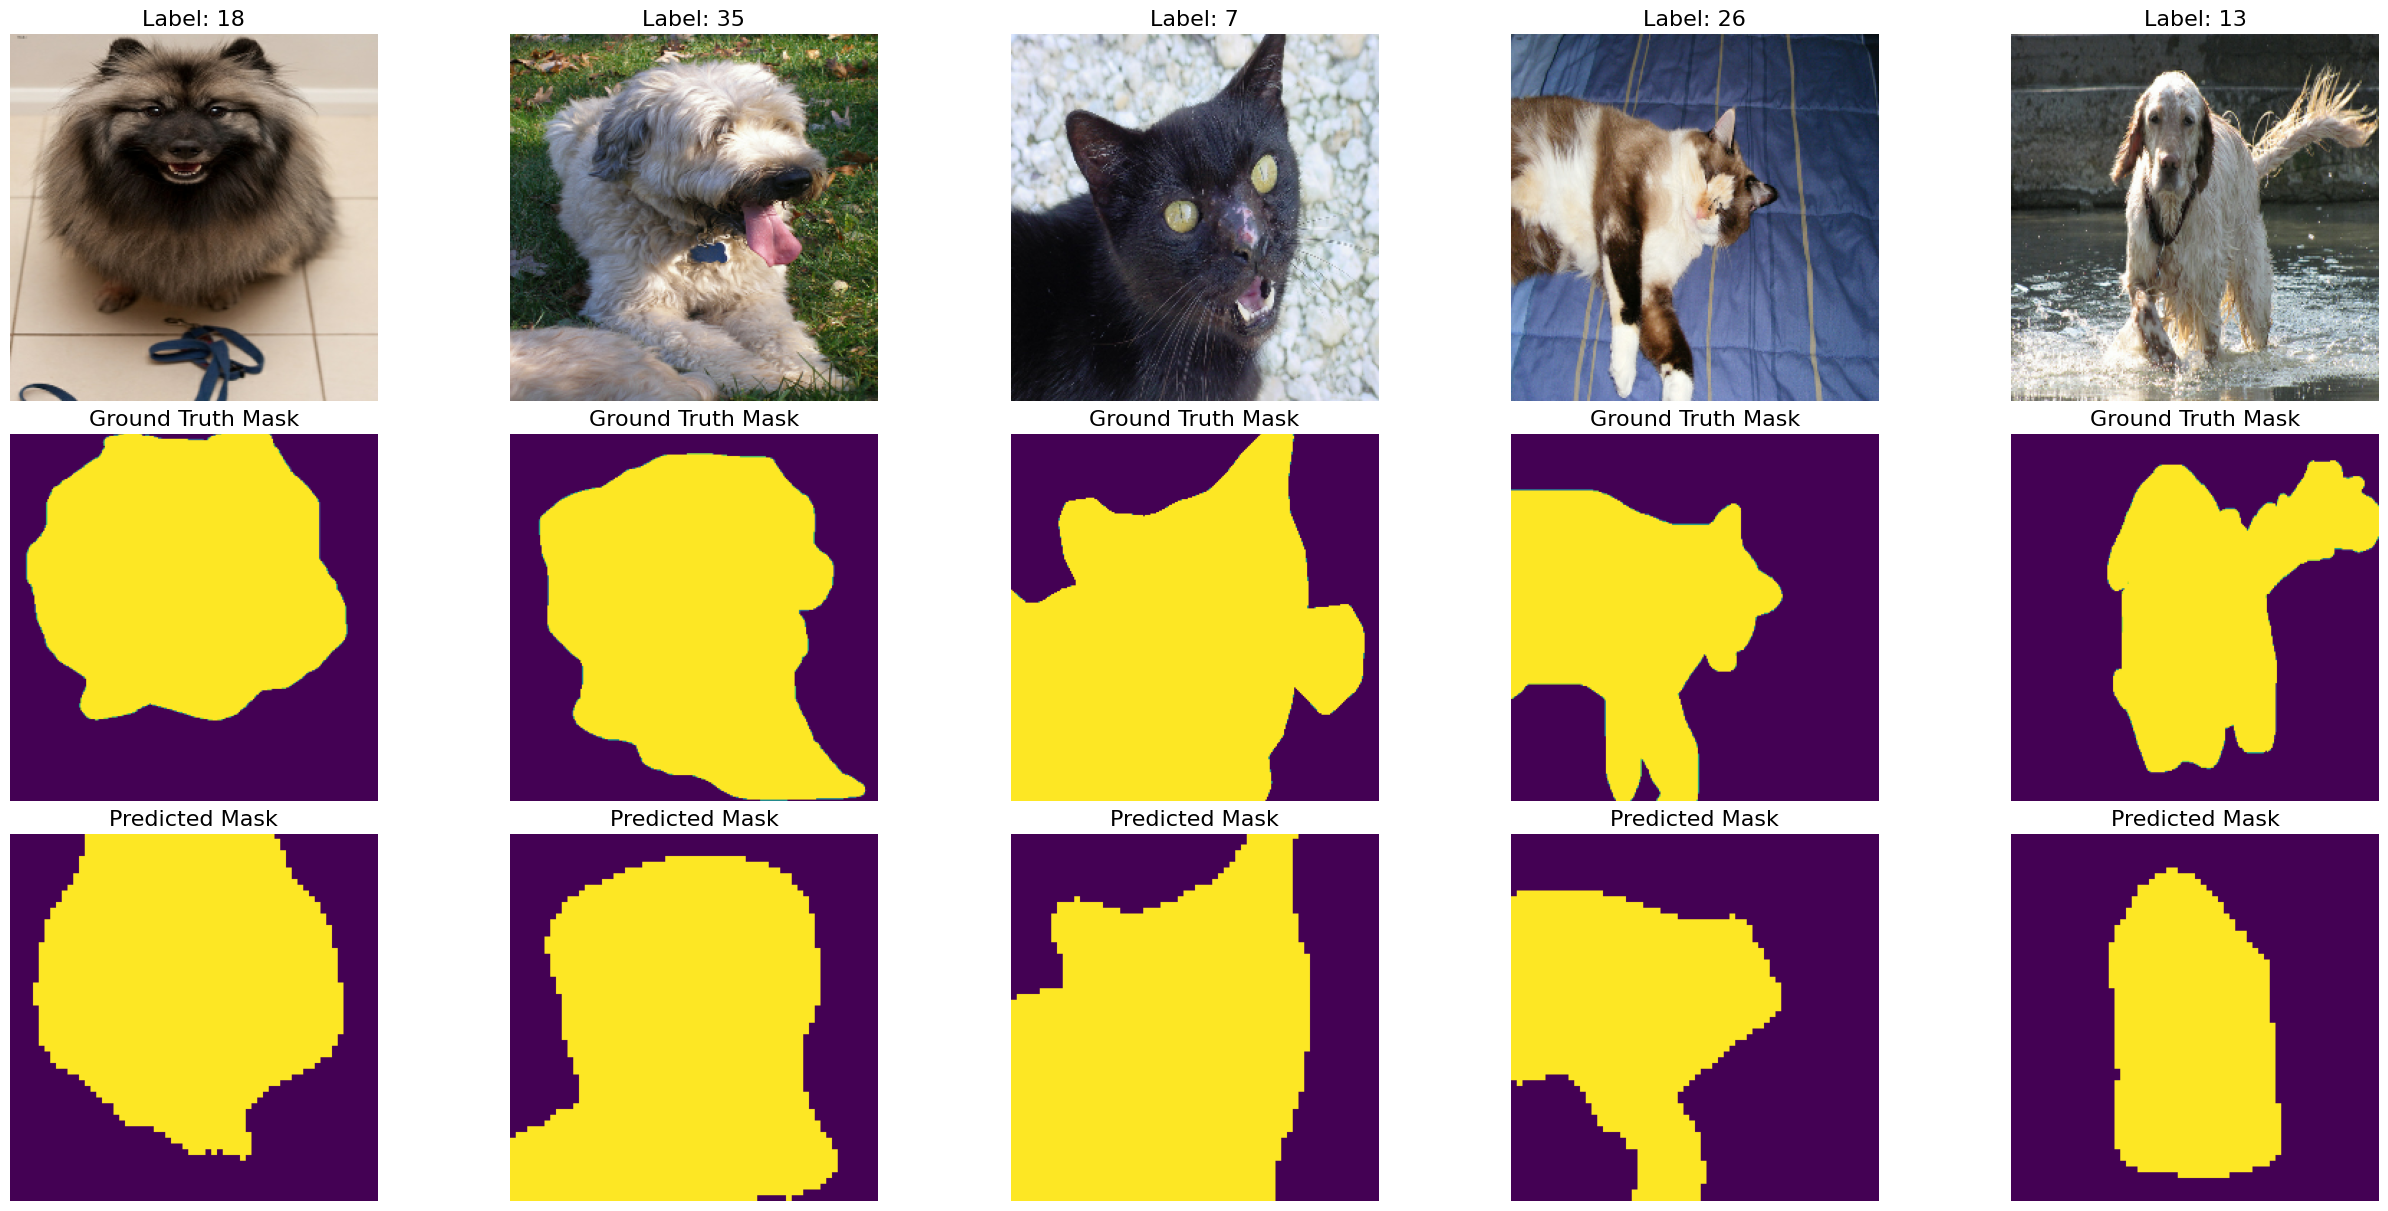

In [25]:
num_plot = 5  # number of samples to display

# Get a single batch from the training dataset and compute model predictions.
for images, outputs in test_class_seg.take(1).as_numpy_iterator():
    # Compute model predictions (assume the model returns a tuple: [classification, segmentation])
    preds = model_mobilenet.predict(images)
    # Extract predicted segmentation masks (second output) and optionally threshold them
    pred_seg = preds[1]  # raw segmentation probabilities

    # Create a 3-row, num_plot-col subplot.
    fig, axs = plt.subplots(3, num_plot, figsize=(25, 12), layout="constrained")
    
    for i in range(num_plot):
        # Row 0: Original image (unprocessed for display) with the ground truth label as title.
        image_disp = np.squeeze(unprocess_image(images[i])) / 255.0  # revert preprocessing
        axs[0, i].imshow(image_disp)
        axs[0, i].set_title(f"Label: {outputs[0][i]}", fontsize=16)
        axs[0, i].axis('off')
        
        # Row 1: Ground-truth segmentation mask.
        axs[1, i].imshow(np.squeeze(outputs[1][i])) #, cmap='gray'
        axs[1, i].set_title("Ground Truth Mask", fontsize=16)
        axs[1, i].axis('off')
        
        # Row 2: Predicted segmentation mask.
        # Here, threshold the predictions at 0.5 so that true is foreground.
        pred_mask = (np.squeeze(pred_seg[i]) > 0.5).astype(np.uint8)
        axs[2, i].imshow(pred_mask)
        axs[2, i].set_title("Predicted Mask", fontsize=16)
        axs[2, i].axis('off')
    
    plt.savefig('doggos_cattos_with_pred_mask1.png')
    plt.show()

In [ ]:
#
# Evaluation
#
# You should evaluate both your networks for both tasks. To help generate metrics and plots, you may want to pull out the labels from the dataset
# which you could do with something like the following:
#
# y_class_test = np.concatenate([y[0] for x,y in test_class_seg.as_numpy_iterator()])
# y_seg_test = np.concatenate([y[1] for x,y in test_class_seg.as_numpy_iterator()])
# 
# For evaluating the two tasks, the classification task is just like all the other classification tasks you've done this semseter and you can follow
# how these have been dealt with. For the segmentation task, one way to look at this is as a binary classification task as you're classifiying each 
# pixel into foreground and background. With that in mind you could do something like this:
#
# class_preds, seg_preds = my_awesome_network.predict(test_class_seg)
# seg_preds_flat = seg_preds.reshape(-1) > 0.5 # flatten predictions, turn into boolean vector where true is fgnd and false is bkgnd
# seg_gt_flat = y_seg_test.reshape(-1) > 0.5 # same as above, but for the ground truth, need to have both as a boolean vector
# cm = sklearn.metrics.confusion_matrix(seg_gt_flat, seg_preds_flat)
#
# You could also look at other segmentation specific metrics as a way to evaluate performance

In [12]:
# For your write-up, you should include:
# - A discussion of what pre-processing (i.e. resizing, colour conversion, augmentation, etc.) you apply to the data and why.
# - Details of two implemented methods. This should include a details of the final “from-scratch” approach and justification 
#   for the chosen design, and details of changes made to MobileNetV3Small for the “fine-tuned” approach. Details on how the 
#   models are trained are also to be provided. 
# - An evaluation that compares the two models for the two tasks (classification and semantic segmentation). Your evaluation 
#   should discuss overall model performance, how it differs between the two approaches, and include figures if/where necessary.
# - A discussion of methods that were explored to improve performance for both models and mitigate identified issues, and potentially 
#   other methods that were considered but not implemented due to computational constraints. See the assignment brief for further 
#   details.
# Your write-up should be supported by appropriate figures and tables. Figures and tables should have numbers and meaningful captions.
# Note that figures and tables are not included in the page limits.
#
# SEE THE ASSIGNMENT BRIEF ON CANVAS FOR MORE DETAILS AND NOTE THAT A NOTEBOOK FILE DOES NOT CONSTITUTE A VALID SUBMISSION. 
# YOU SHOULD WRITE UP YOUR RESPONSE IN A SEPARATE DOCUMENT